In [15]:
import os
import sys
import csv
import ast
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 14})


In [52]:
class ReadWriteData():
    def __init__(self, path1, name):
        self.root_directory = os.path.join(path1, name, 'env_params')
        self.root_dir = path1
        self.name = name
        self.home = self.root_dir.split('/')[-1].split('-')[-1]
        self.data = {}
        self.all_dfs = {}
        self.first_last = {}
        self.missing_days = []
        self.num_folders = 288
        self.files_per = 5
        self.total_minutes = {}

        
    def csv_name(self, day):       
        return str(self.home + '_' + self.name + '_' + day + '.csv')  

    def mylistdir(self, directory):
        filelist = os.listdir(directory)
        return [x for x in filelist if not (x.startswith('.') or 'Icon' in x)]           
    
    
    def make_storage_directory(self, root):
        target_dir = os.path.join(root, 'csv')
        if os.path.exists(target_dir):
            return target_dir
        else:
            os.mkdir(target_dir)
            return target_dir

        
    def read_in_data(self, path, day):
        with open(path, 'r') as f:
            try:
                self.data_dicts = json.loads(f.read())
                for time_point in self.data_dicts:
                    for measure in time_point:
                        self.measurements[measure].append(time_point[measure])
            except:
                pass
            
            
    def get_date_folders(self, path):
        date_folders = self.mylistdir(path)
        date_folders.sort()
        self.day1, self.dayn = date_folders[0], date_folders[-1]
        return date_folders
    
    
    def get_all_data(self, path, day):
        self.measurements = {
            'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
            'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
        file_path = os.path.join(path, day)
        minute_folders = self.mylistdir(file_path)
        minute_folders.sort()
        num_missing = self.num_folders - len(minute_folders)
        min_1, min_L = minute_folders[0], minute_folders[-1]
        min_n = str(int(min_L) + 4).zfill(4)
        self.first_last[day] = min_1, min_n
        for minute in minute_folders:
            sub_files_path = os.path.join(file_path, minute)
            sub_files = self.mylistdir(sub_files_path)
            missing = self.files_per - len(sub_files)
            num_missing += missing
            for file in sub_files:
                if file.endswith('.json') == True:
                    self.read_in_data(os.path.join(sub_files_path, file), day)
        
        self.data[day] = self.measurements
        self.total = 1440 - num_missing
        self.total_minutes[day] = self.total
            
    def make_date_range(self, day1, dayn = None, t1 = '0000', tn = '2359'):
        self.range_start = str(day1 + ' ' + t1[0:2] + ':' + t1[2:4] + ':00')
        self.range_end = str(day1 + ' ' + tn[0:2] + ':' + tn[2:4] + ':50')
        date_range = pd.date_range(start=self.range_start, end=self.range_end, freq='10s')
        return date_range              
            
    def create_full_dfs(self, df, day):
        #df2 = df.loc[df['date'] == f]         
        day_start, day_end = self.first_last[day][0], self.first_last[day][1]
        df_inner = self.make_date_range(day, t1 = day_start, tn = day_end)      
        #df_fullday = self.make_date_range(day1 = day, dayn = day) ##use this for full 24hours
        df2 = df.reindex(df_inner, fill_value = 0) 
        df2.fillna('missing')
        return df2 
                   
    
    def clean_dates(self, df, day): 
        df['time'] = df['time'].str.strip('Z').str.replace('T',' ')
        df['datetime_index'] = pd.to_datetime(df['time'])         
        df = df.set_index('datetime_index')
        df.index = df.index.floor('10s')
        df2 = self.create_full_dfs(df, day)        
        str_date = df2.index.strftime('%Y-%m-%d %H:%M:%S')
        df2.insert(loc = 0, column = 'str_datetime', value = str_date)
        datetime_col = df2['str_datetime'].str.split(' ', n = 1, expand = True)         
        df2.insert(loc = 0, column = 'date', value = datetime_col[0])
        df2.insert(loc = 0, column = 'time-hr-min-sec', value = datetime_col[1])
        time_col = datetime_col[1].str.split(':', n = 2, expand = True)    
        df2.insert(loc = 0, column = 'second', value = time_col[2])
        df2.insert(loc = 0, column = 'minute', value = time_col[1])
        df2.insert(loc = 0, column = 'hour', value = time_col[0])        
        df2 = df2.drop(columns = ['str_datetime', 'time'])
        df2 = df2.sort_values(by = ['date', 'hour', 'minute', 'second'])
        df2['home'] = self.home
        df2['sensor'] = self.name
        return df2
    
    def absolute_humidity(self, df, day):
        #df['abs_humid'] = 13.247*df['rh_percent']*(np.exp((17.67*df['temp_c'])/(243.5+df['temp_c']))/(273.15+df['temp_c']))
        df['abs_humid'] = 13.247*df['rh_percent']*(2.718281828459045**((17.67*df['temp_c'])/(243.5+df['temp_c']))/(273.15+df['temp_c']))
        return df
 
    
    def get_ground_truth(self):
        ground_path = os.path.join(self.root_dir, 'GroundTruth')
        occupant_files = self.mylistdir(ground_path)
        occupants = {}
        for occ in occupant_files:
            occupant_name = occ.strip('.csv').split('-')[1]
            ishome = []
            with open(os.path.join(ground_path, occ)) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                for row in csv_reader:
                    status, when = row[1], row[2].split('at')
                    dt_day = datetime.strptime(str(when[0] + when[1]), '%B %d, %Y  %I:%M%p')
                    ishome.append((status, dt_day))
            occupants[occupant_name] = ishome
        return occupants
    
        
    def attach_ground_truth(self, df, occupants):
        for occ in occupants:
            df[occ] = 99
            s1 = 'exited'
            for r in occupants[occ]:
                date = r[1]
                s2 = r[0]
                df.loc[(df.index < date) & (df[occ]==99) & (s1 == 'entered') & (s2 == 'exited'), occ] =  1
                df.loc[(df.index < date) & (df[occ]==99) & (s1 == 'exited') & (s2 == 'entered'), occ] =  0
                s1 = s2
        df['number'] = df[list(occupants.keys())].sum(axis = 1)
        df['occupied'] = 0
        df.loc[df['number'] > 0, 'occupied'] = 1
        return(df)        
        
      

    def write_data(self, all_dfs, folders):
        storage_path = self.make_storage_directory(self.root_dir)
        for f in folders:
            if f in self.missing_days:
                print('No data for day {}'.format(f))
                continue
            target_fname = os.path.join(storage_path, self.csv_name(f)) 
            df_to_write = all_dfs[f]
            if os.path.isfile(target_fname) is False:
                df_to_write.to_csv(target_fname, index = True)
                print(target_fname + ': Write Sucessful!')
            else:
                print(target_fname + ': File already exists')

                   
                    
    def main(self):        
        date_folders = self.get_date_folders(self.root_directory)
        occupancy = self.get_ground_truth()
                
        for day in date_folders:
            self.get_all_data(self.root_directory, day)
            new_df = pd.DataFrame.from_dict(self.data[day])
            
            if new_df.empty:
                self.missing_days.append(day)
                self.first_last[day] = ('0000', '0000')
                continue
            new_df = self.absolute_humidity(new_df, day)
            cleaned_data = self.clean_dates(new_df, day)
            dfwTruth = self.attach_ground_truth(cleaned_data, occupancy)
            self.all_dfs[day] = dfwTruth
        
        self.write_data(self.all_dfs, date_folders)

        

In [53]:
root_path = '/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5'
sensors_black = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6']
sensors_red = ['RS1']#, 'RS2', 'RS3', 'RS4', 'RS5']



all_dfs = {}
first_last = {}

for sensor in sensors_red:
    P = ReadWriteData(root_path, sensor)
    P.main()
    all_dfs[sensor] = P.all_dfs
    for day in P.first_last.keys():
        try:
            #perc = '{:.2f}'.format(len(P.all_dfs[day])/8640)
            total = P.total_minutes[day]/1440
            perc = '{:.2f}'.format(total)
        except:
            perc = 0.00
        F1, F2 = P.first_last[day][0], P.first_last[day][1]
        s = (f'({F1[0:2]}:{F1[2:4]}, {F2[0:2]}:{F2[2:4]})')
        print(sensor, day, s, perc)

    


/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-03.csv: Write Sucessful!
/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-04.csv: Write Sucessful!
/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-05.csv: Write Sucessful!
/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-06.csv: Write Sucessful!
No data for day 2019-06-07
No data for day 2019-06-08
No data for day 2019-06-09
No data for day 2019-06-10
No data for day 2019-06-11
No data for day 2019-06-12
No data for day 2019-06-13
No data for day 2019-06-14
No data for day 2019-06-15
No data for day 2019-06-16
No data for day 2019-06-17
/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-18.csv: Write Sucessful!
/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-19.csv: Write Sucessful!
/Users/maggie/Desktop/HPD_mobile_data/HPD_mobile-H5/csv/H5_RS1_2019-06-20.csv: Write Sucessful!
/Users/maggie/Desktop/HPD_mobil

dict_keys(['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6'])


In [3]:
class PlottingData():
    def __init__(self, dfs, measures, limits, colors, units, names):
        self.all_dfs = dfs
        self.measures = measures
        self.limits = limits
        self.colors = colors
        self.names = names
        self.units = units
            
    def get_all(self):
        for sensor in self.all_dfs:
            print(sensor)
            for m, measure in enumerate(self.measures):
                print(measure)
                for date in self.all_dfs[sensor]:
                    print(date)
                    df = self.all_dfs[sensor][date]
                    df2 = df.loc[df['date'] == date, ['time-hr-min-sec', measure]]                
                    for row in df2.iterrows():
                        if row[1][1] is None:
                            row[1][1] = np.NaN
                    if measure in self.limits:        
                        low, high = self.limits[measure][0], self.limits[measure][1]        
                        if measure  == 'temp_c':
                            df2.loc[(df2.temp_c <= low), 'temp_c'] = np.NaN
                            df2.loc[df2.temp_c > high, 'temp_c'] = np.NaN
                        if measure == 'rh_percent':
                            df2.loc[df2.rh_percent <= low, 'rh_percent'] = np.NaN
                            df2.loc[df2.rh_percent > high, 'rh_percent'] = np.NaN
                        if measure == 'tvoc_ppb':
                            df2.loc[df2.tvoc_ppb > high, 'tvoc_ppb'] = np.NaN                                            
                        if measure == 'co2eq_ppm':
                            df2.loc[df2.co2eq_ppm < low, 'co2eq_ppm'] = np.NaN
                            df2.loc[df2.co2eq_ppm > high, 'co2eq_ppm'] = np.NaN
                        if measure == 'abs_humid':
                            df2.loc[df2.abs_humid < low, 'abs_humid'] = np.NaN
                            df2.loc[df2.abs_humid > high, 'abs_humid'] = np.NaN
                            
                    try:                
                        fig, ax = plt.subplots(figsize = (8,5))

                        ax.plot(df2[measure], color = self.colors[m])
                        unit = self.units[measure]
                        name = self.names[measure]
                        ax.set_ylabel(unit)

                        #title = '{} : {}, {}'.format(name, sensor, date)
                        title = str(name + ', ' + sensor + ' : ' + date)
                        #fname = '{}_{}_{}'.format(date_sensor_name)      
                        fname = str(date +'_'+ sensor +'_'+ measure +'.png')
                        ax.set_xlabel('Hour')
                        plt.title(title)
                        

                        myFmt = mdates.DateFormatter('%H')
                        ax.xaxis.set_major_formatter(myFmt) 
                        fig.autofmt_xdate()
                        
                        plt.savefig(fname)

                        plt.show()
                    except:
                        pass
                    
               
            
    def main(self):
        self.get_all()

BS6
abs_humid
2019-02-23


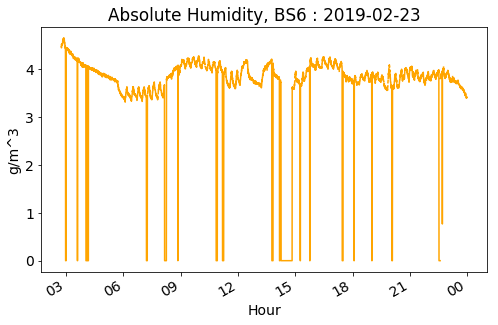

2019-02-24


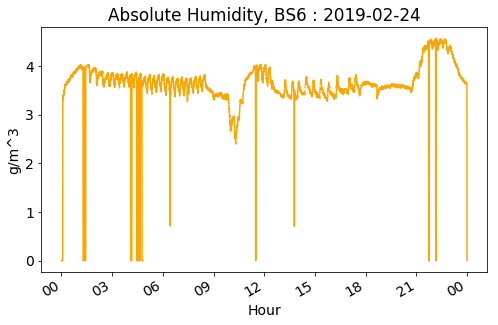

2019-02-25


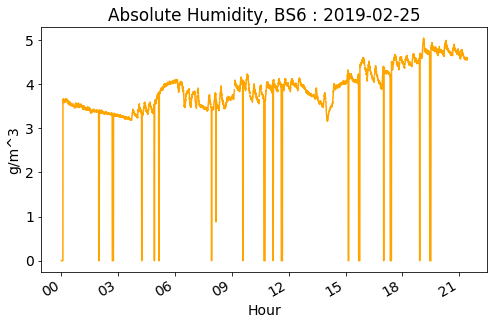

2019-02-26


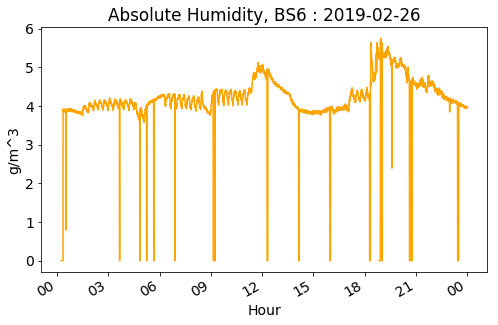

2019-02-27


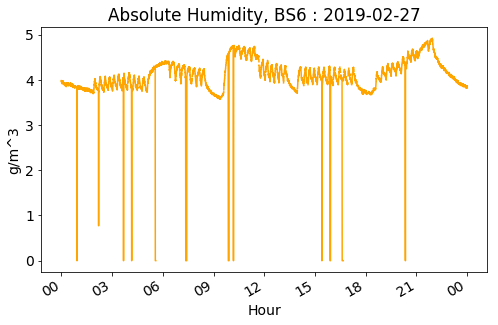

2019-02-28


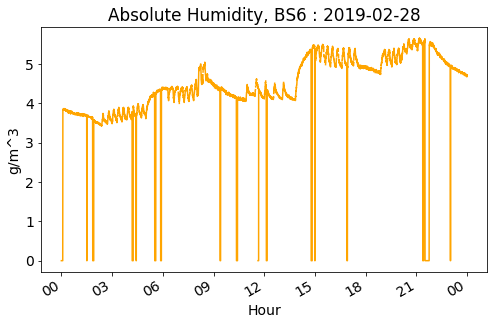

2019-03-01


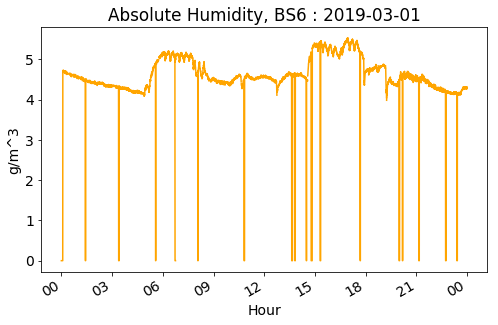

2019-03-02


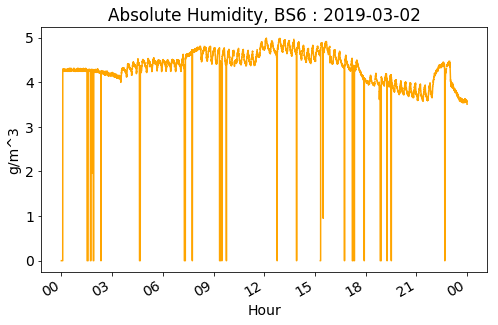

2019-03-03


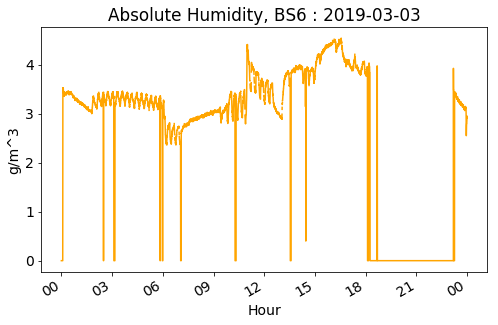

2019-03-04


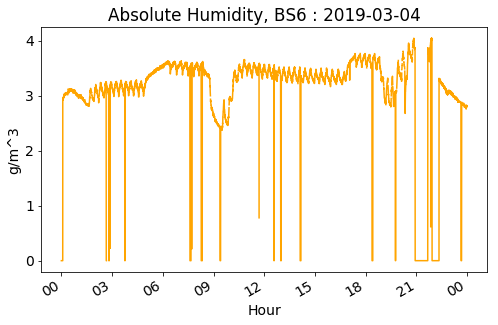

2019-03-05


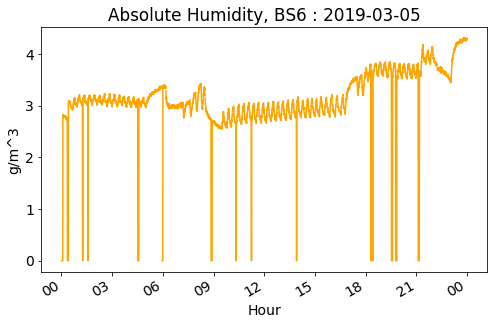

2019-03-06


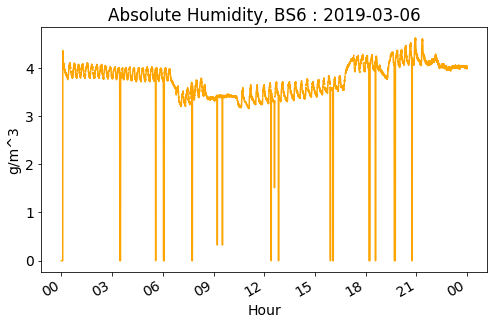

2019-03-07


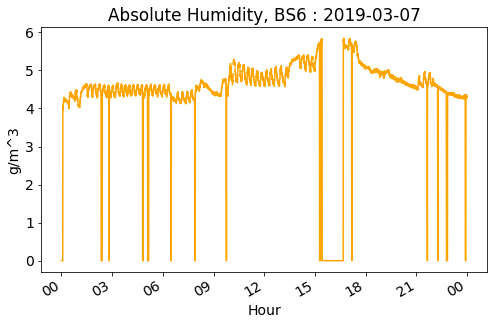

2019-03-08


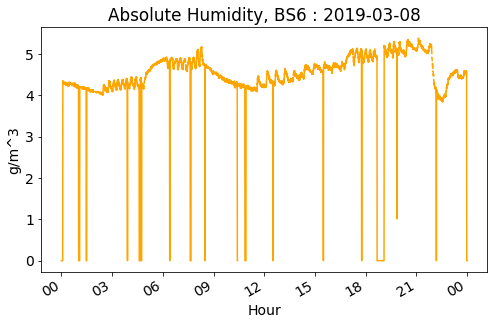

2019-03-09


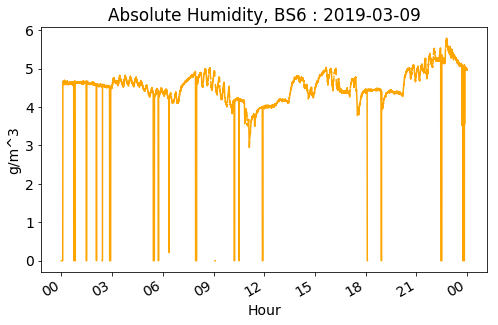

2019-03-10


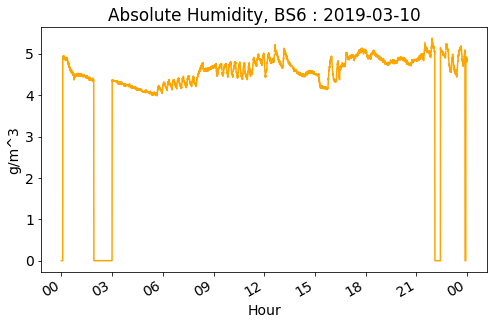

2019-03-11


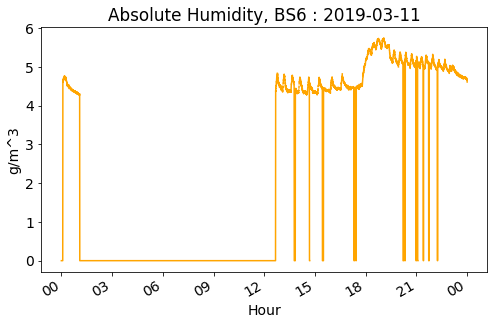

2019-03-12


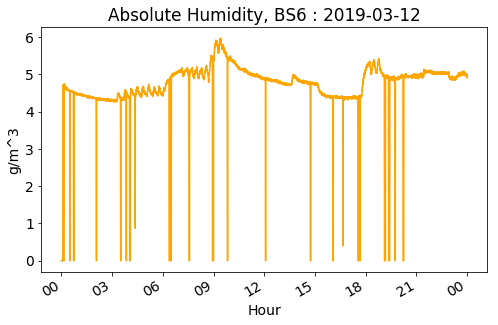

2019-03-13


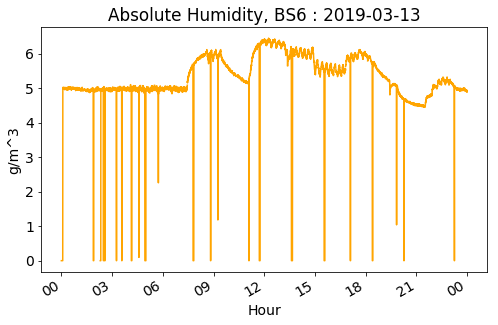

2019-03-14


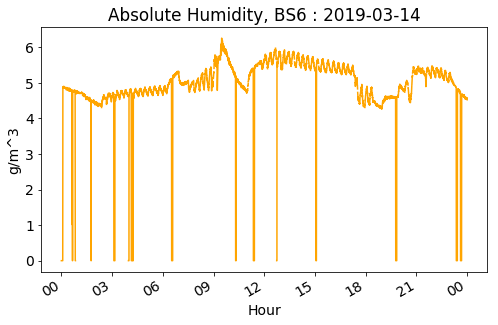

2019-03-15


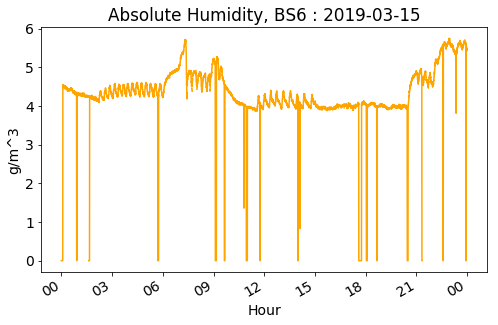

2019-03-16


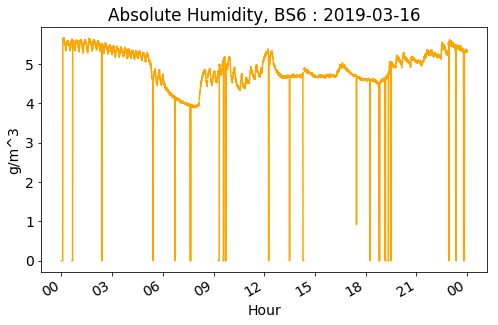

2019-03-17


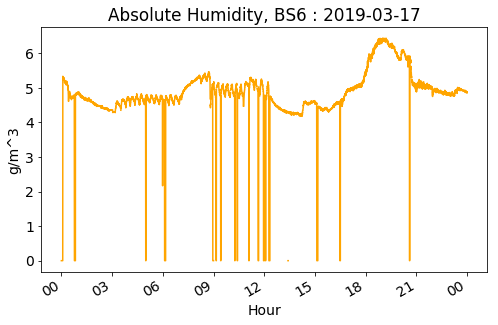

2019-03-18


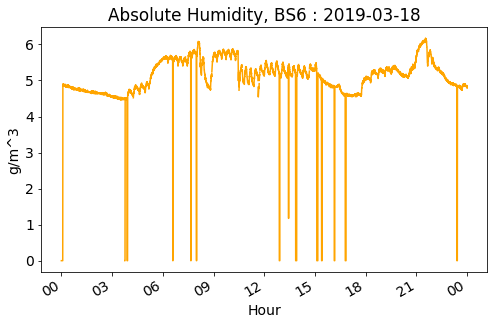

2019-03-19


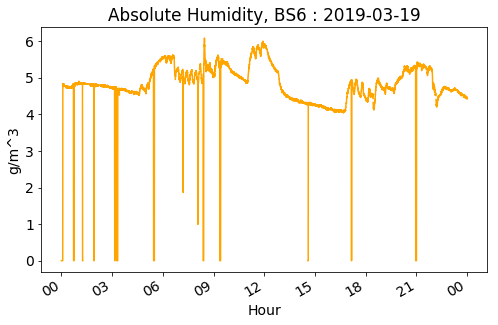

2019-03-20


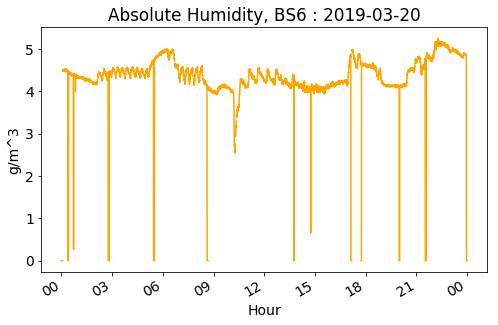

2019-03-21


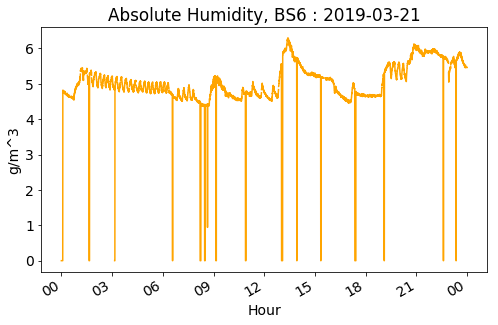

2019-03-22


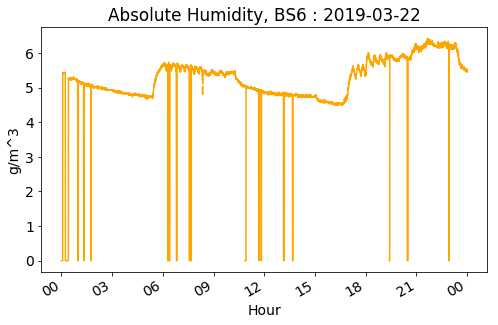

2019-03-23


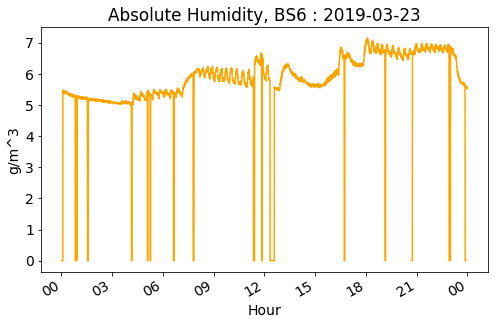

2019-03-24


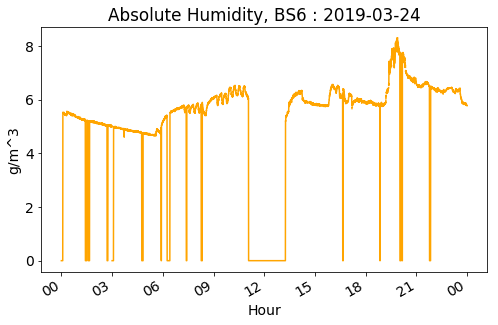

2019-03-25


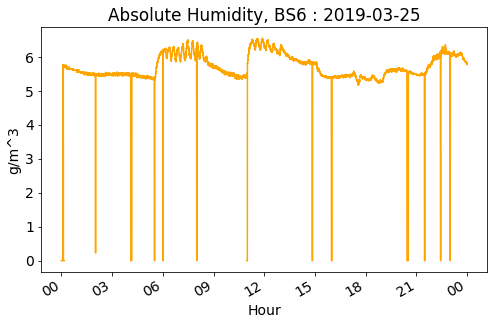

2019-03-26


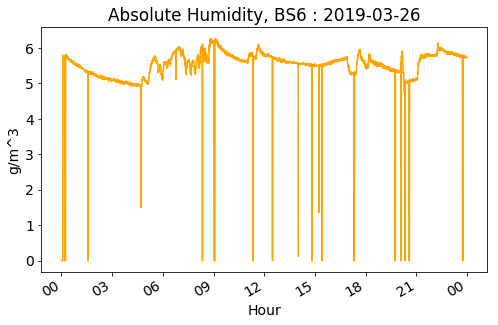

2019-03-27


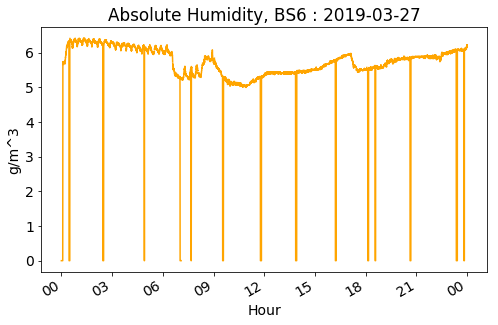

2019-03-28


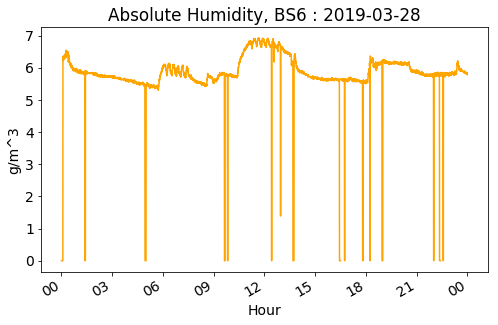

2019-03-29


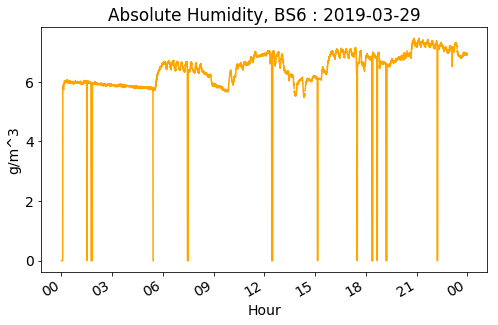

2019-03-30


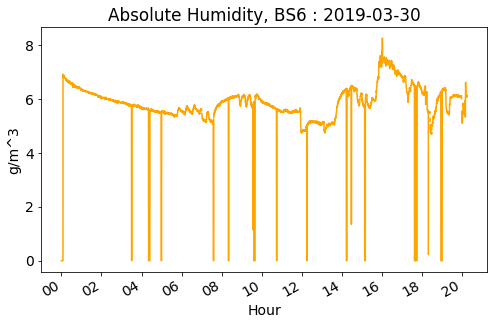

In [167]:
measures_to_plot = ['tvoc']
max_min = {'abs_humid': [0,15]}

units = {'temp_c': 'Degree C', 'rh_percent': '%','abs_humid':'g/m^3' ,'light_lux': 'Lux',
         'tvoc_ppb': 'Parts per billion','co2eq_ppm': 'Parts per million','dist_mm': 'mm'}

names = {'temp_c': 'Temperature', 'rh_percent': 'Relative Humidity','abs_humid': 'Absolute Humidity','light_lux': 'Light Level',
         'tvoc_ppb': 'Total Volatile Organic Compounds','co2eq_ppm': 'CO2 Equivalent','dist_mm': 'Distance to Object'}

#                         title = str('{} - {}, {}'.format(name, sensor, date))
#                         fname = str('{}_{}_{}'.format(date_sensor_name))           


colors = ['blue']

G = PlottingData(all_dfs, measures_to_plot, max_min, colors, units, names)

G.main()

BS6
temp_c
2019-02-23


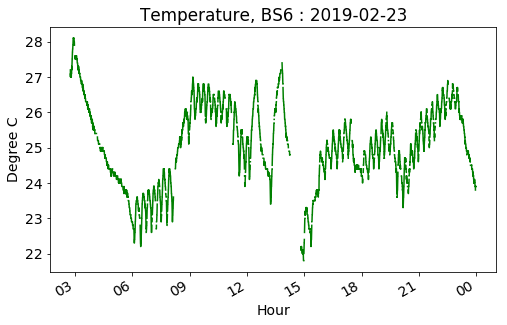

2019-02-24


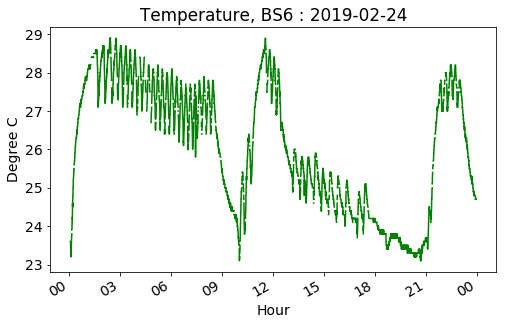

2019-02-25


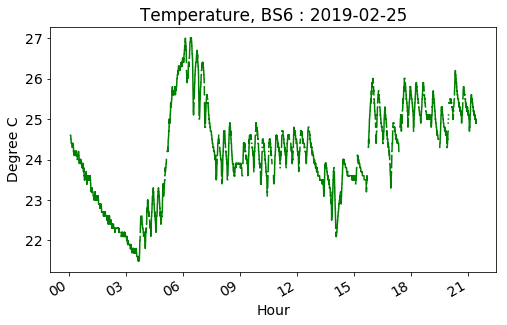

2019-02-26


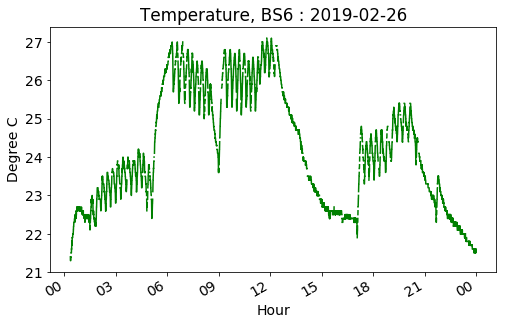

2019-02-27


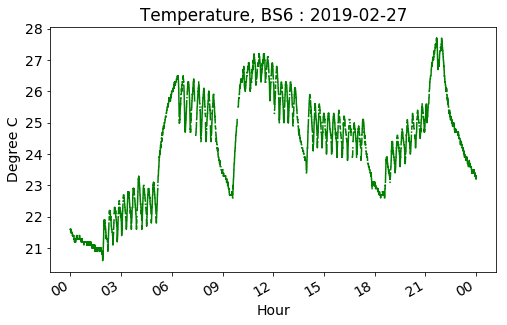

2019-02-28


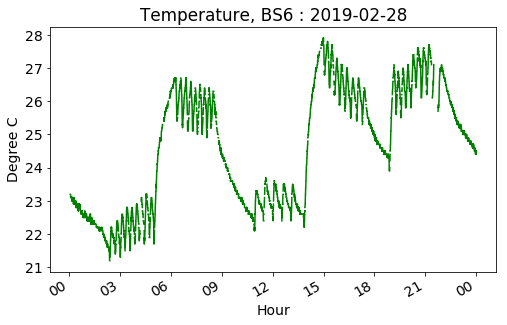

2019-03-01


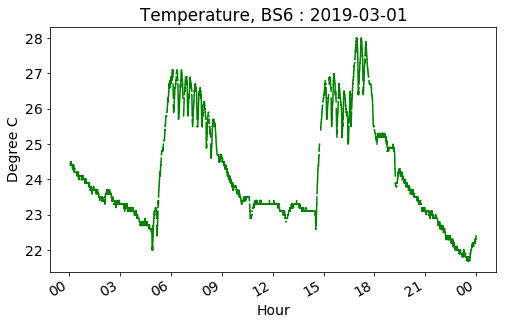

2019-03-02


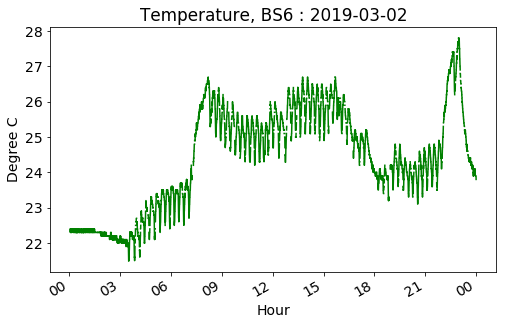

2019-03-03


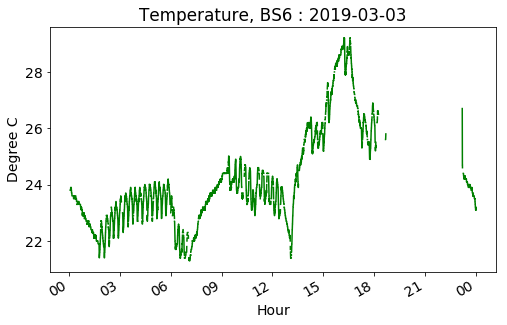

2019-03-04


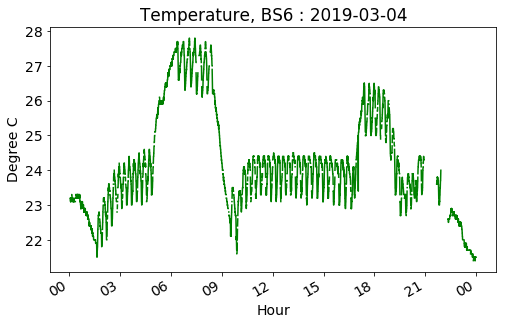

2019-03-05


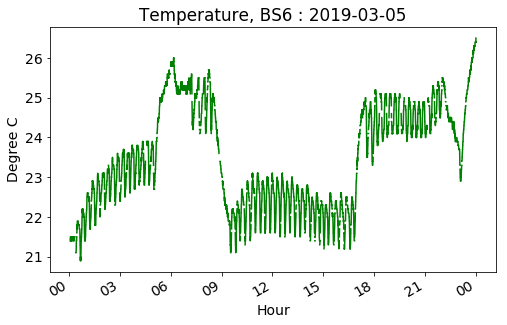

2019-03-06


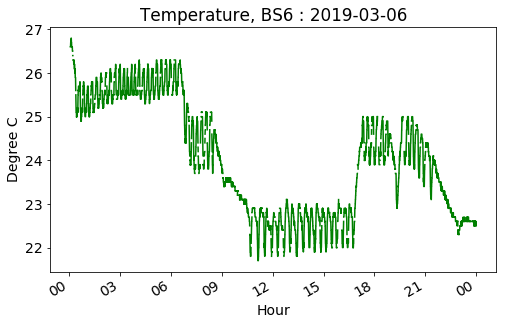

2019-03-07


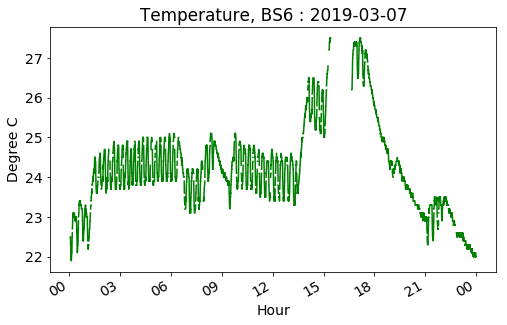

2019-03-08


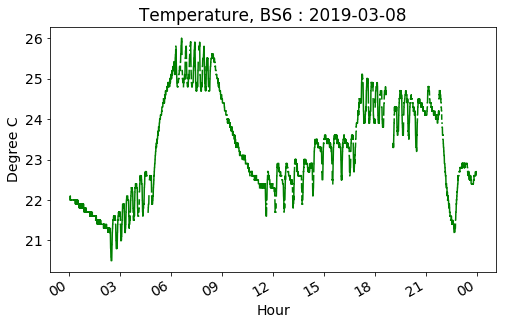

2019-03-09


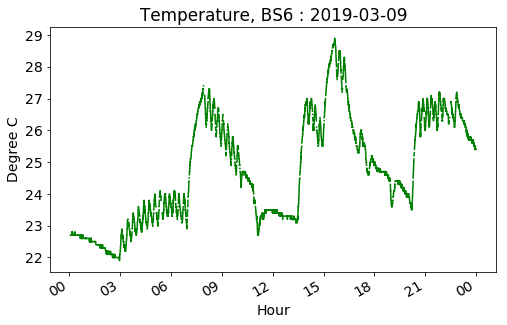

2019-03-10


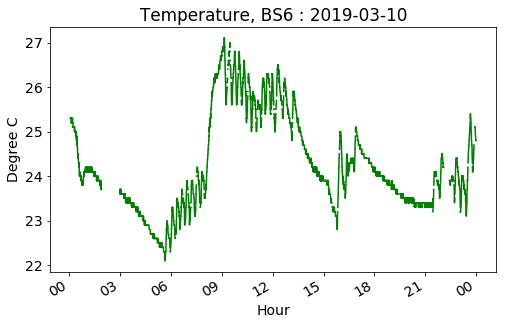

2019-03-11


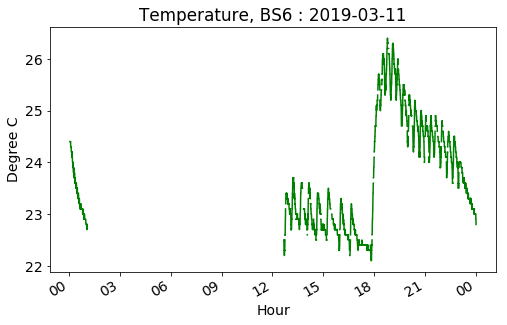

2019-03-12


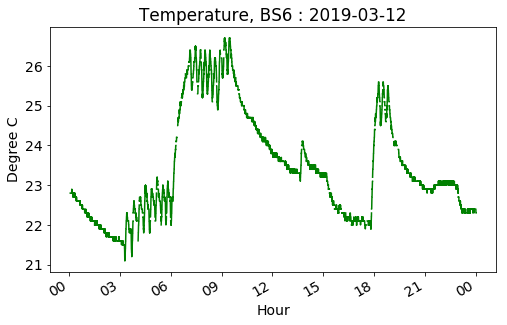

2019-03-13


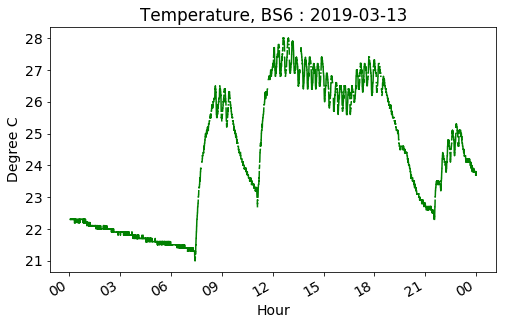

2019-03-14


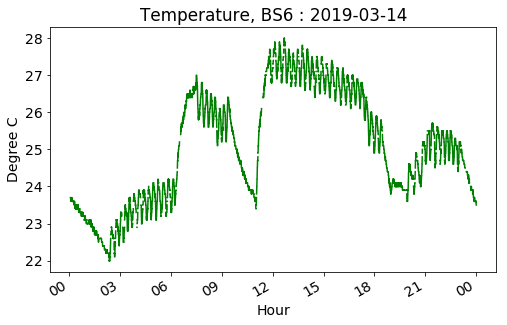

2019-03-15


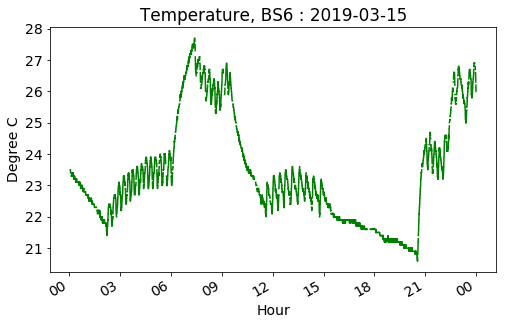

2019-03-16


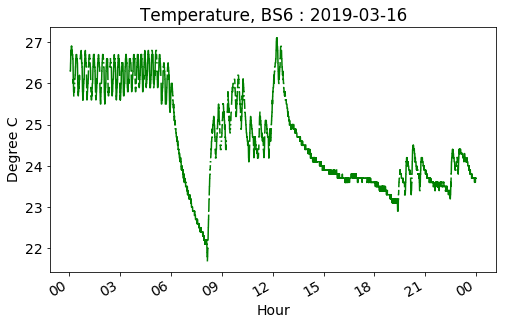

2019-03-17


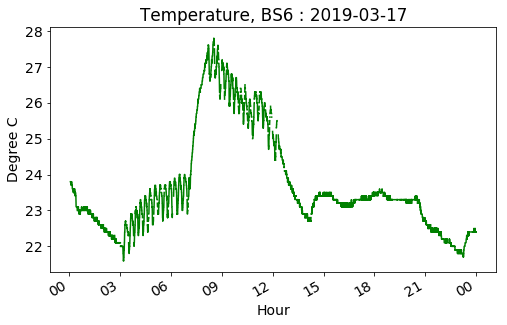

2019-03-18


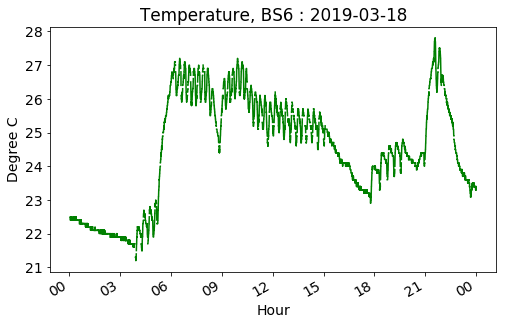

2019-03-19


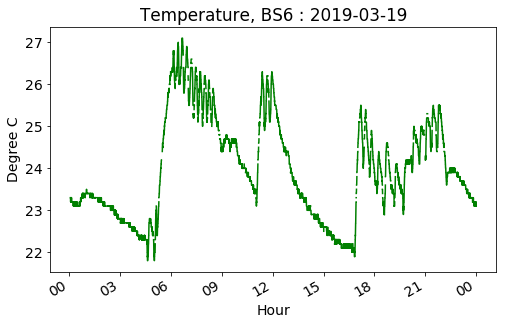

2019-03-20


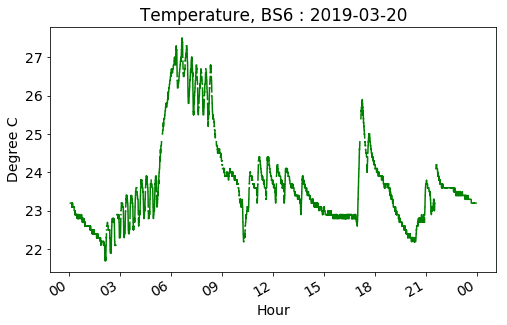

2019-03-21


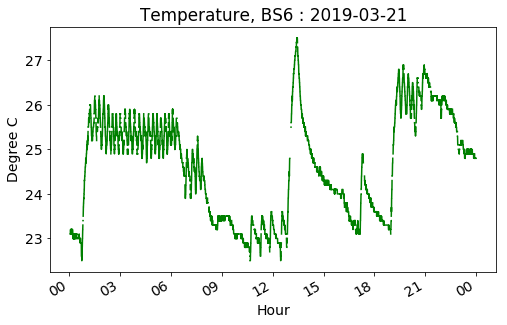

2019-03-22


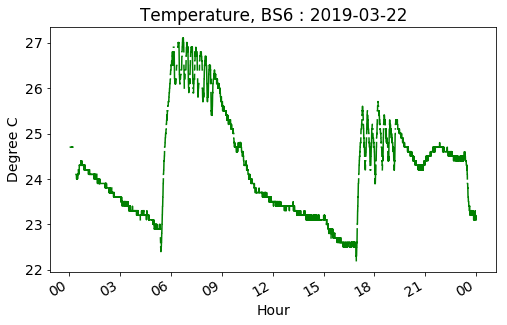

2019-03-23


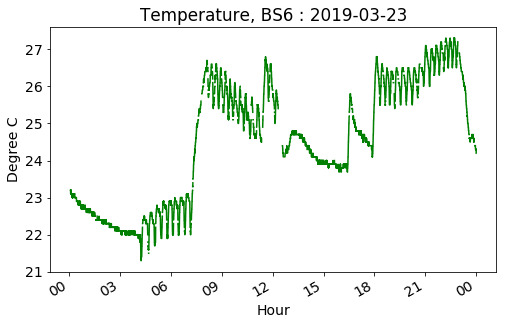

2019-03-24


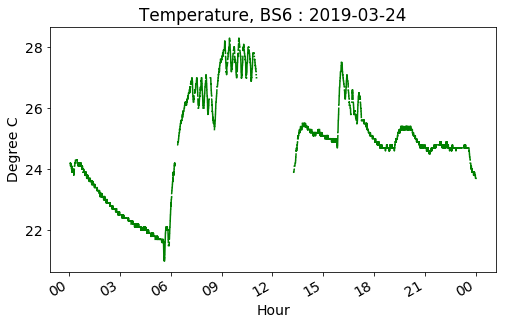

2019-03-25


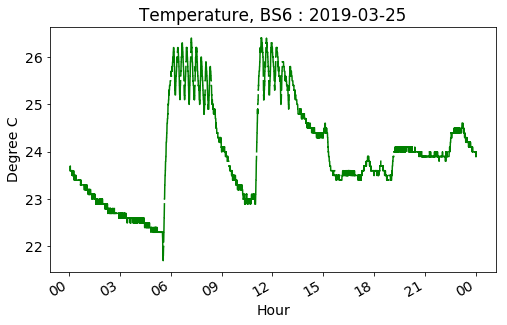

2019-03-26


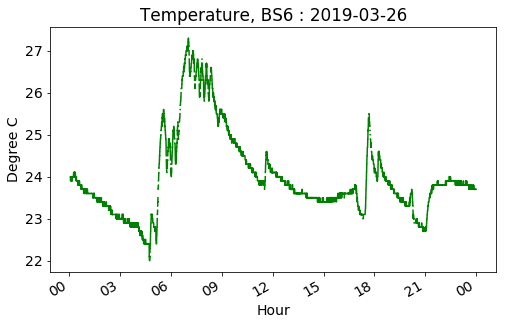

2019-03-27


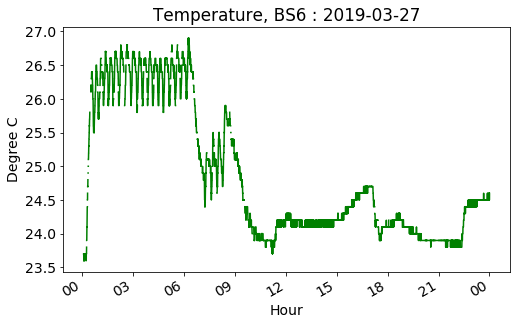

2019-03-28


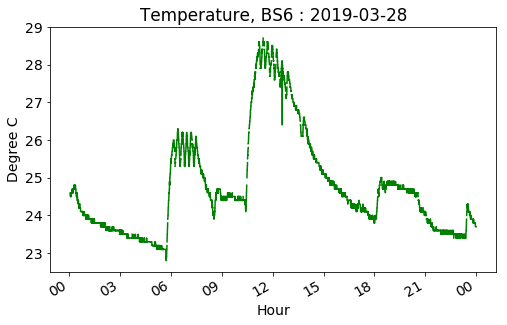

2019-03-29


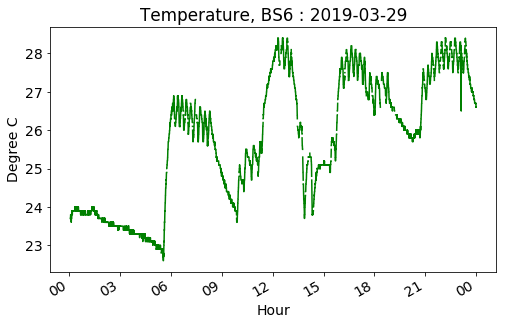

2019-03-30


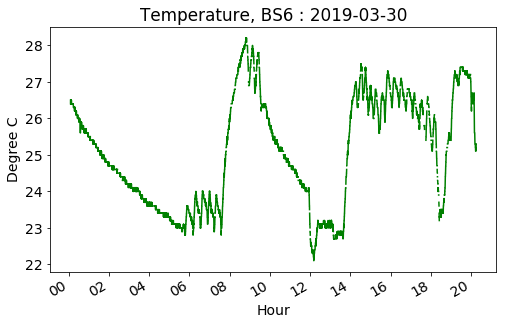

rh_percent
2019-02-23


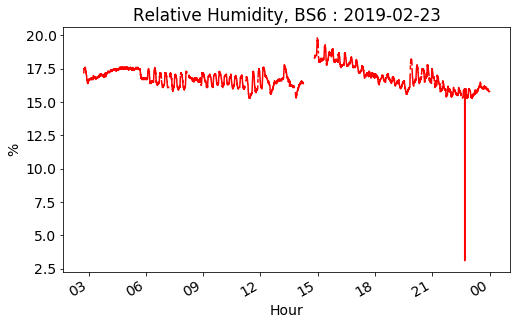

2019-02-24


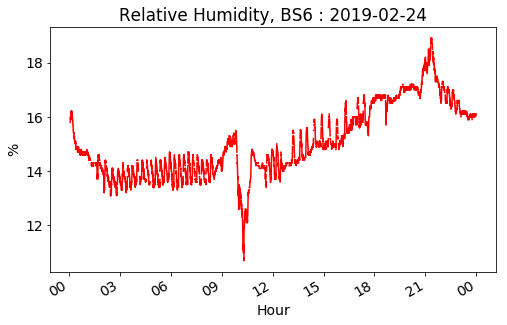

2019-02-25


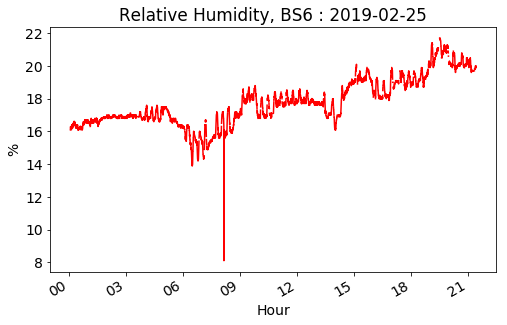

2019-02-26


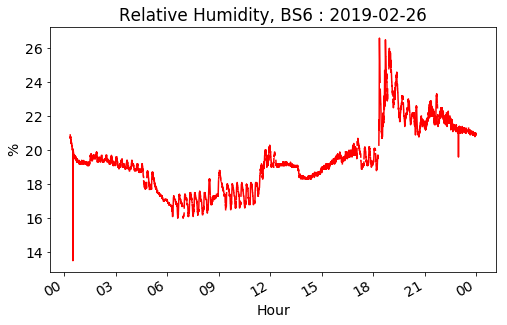

2019-02-27


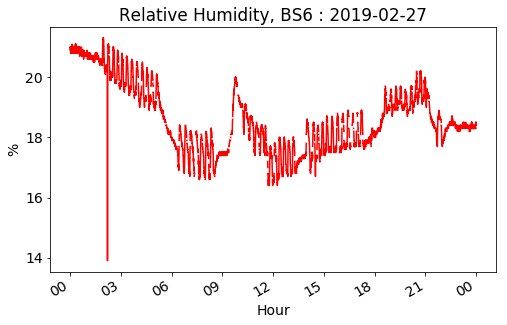

2019-02-28


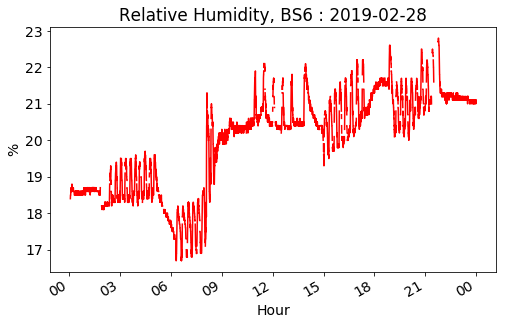

2019-03-01


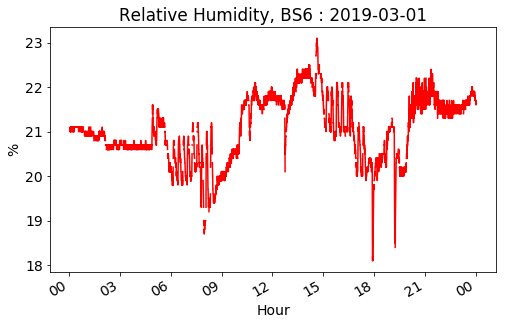

2019-03-02


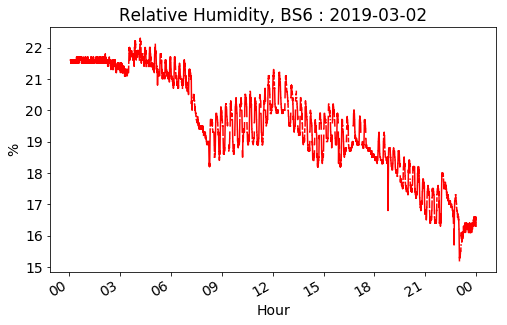

2019-03-03


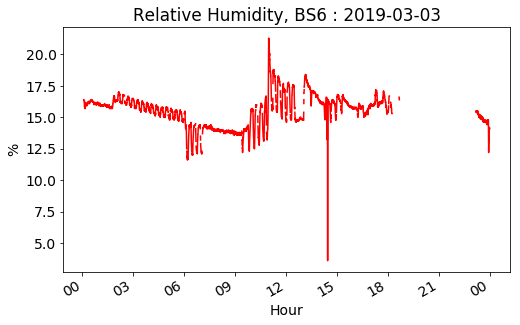

2019-03-04


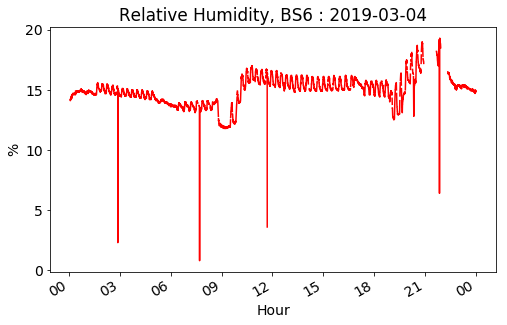

2019-03-05


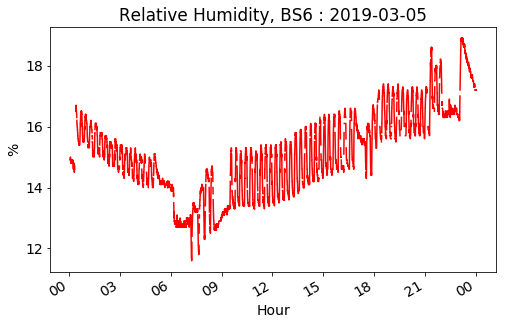

2019-03-06


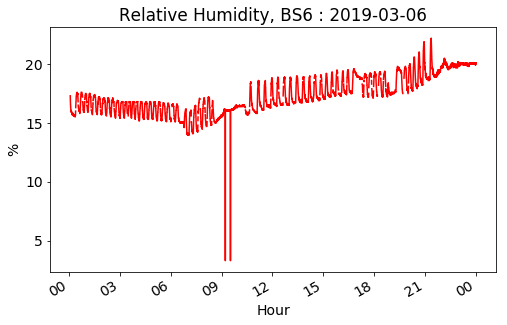

2019-03-07


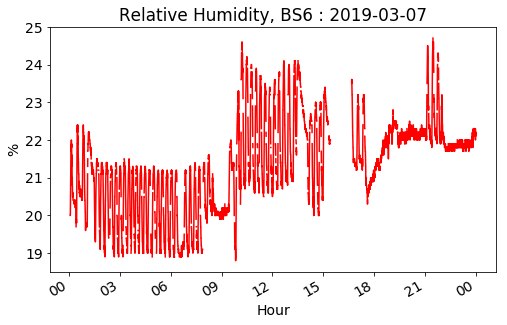

2019-03-08


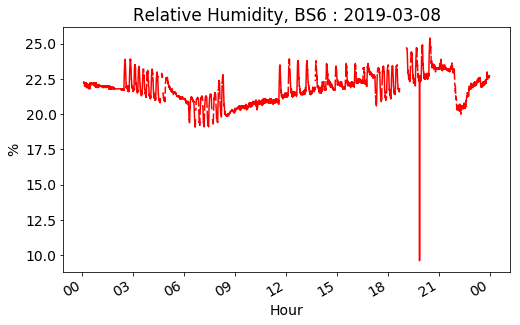

2019-03-09


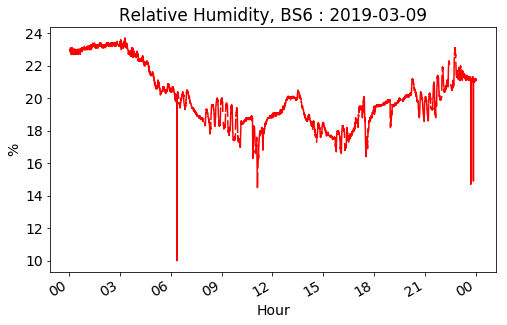

2019-03-10


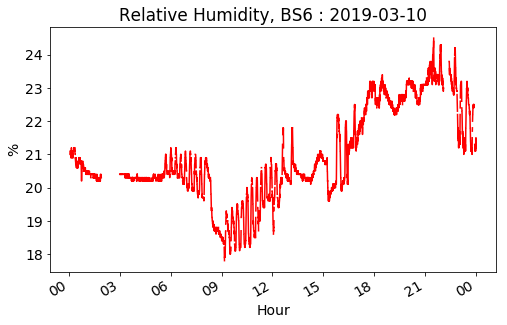

2019-03-11


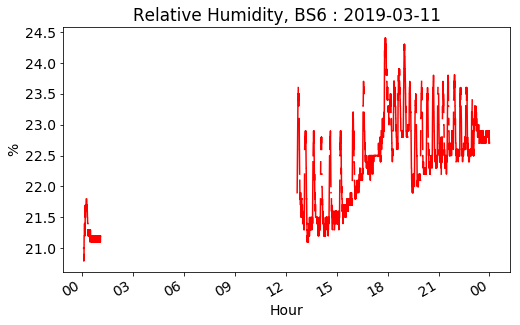

2019-03-12


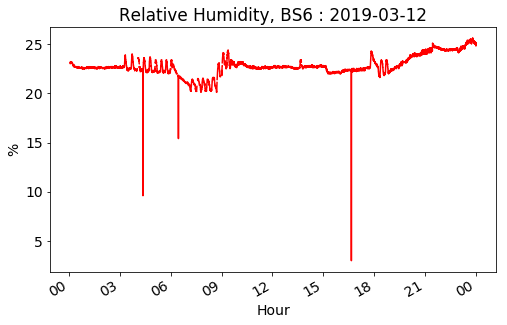

2019-03-13


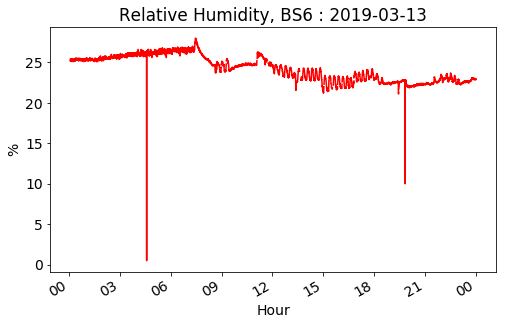

2019-03-14


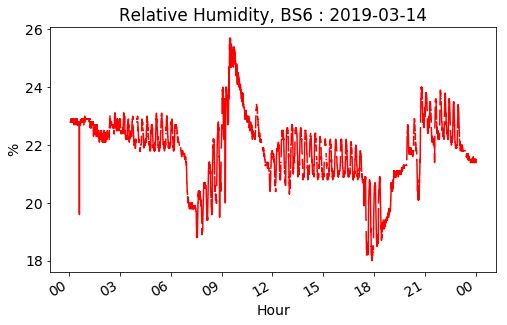

2019-03-15


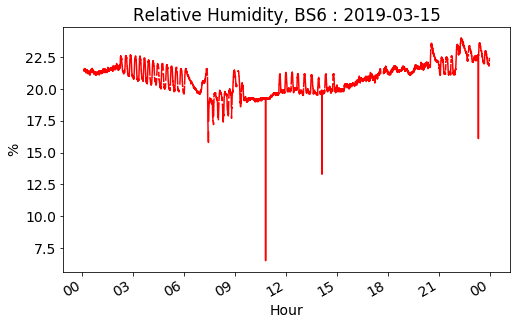

2019-03-16


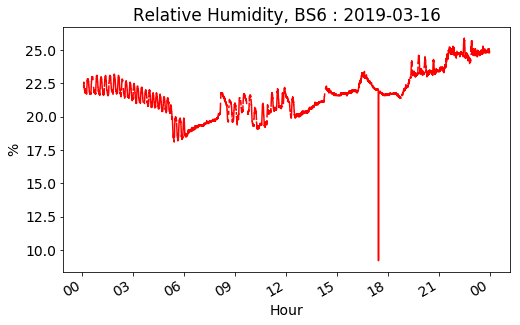

2019-03-17


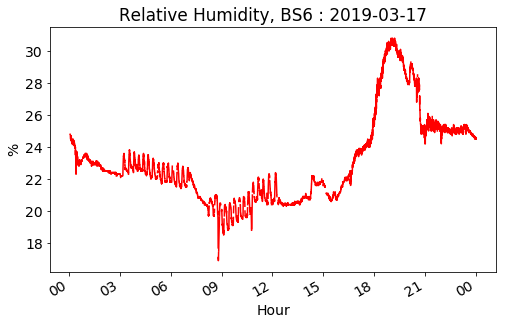

2019-03-18


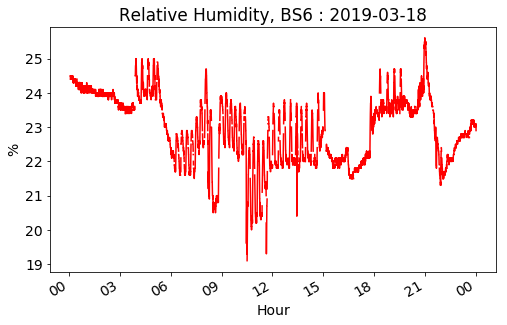

2019-03-19


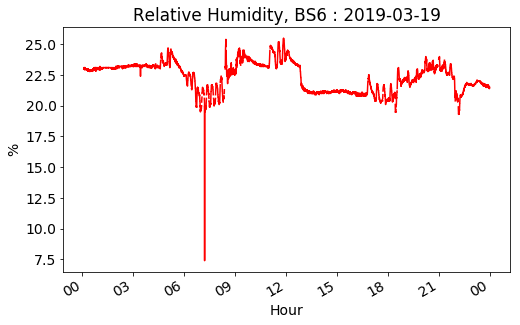

2019-03-20


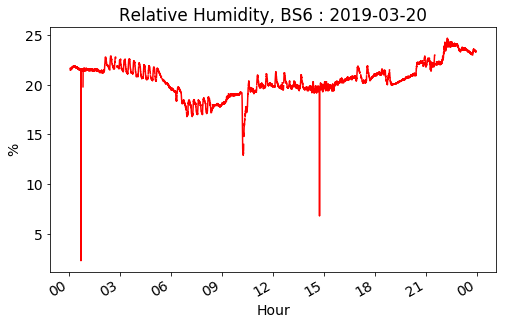

2019-03-21


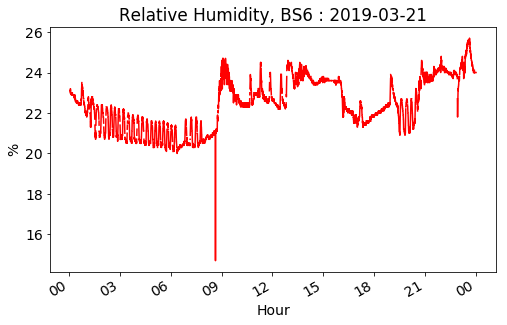

2019-03-22


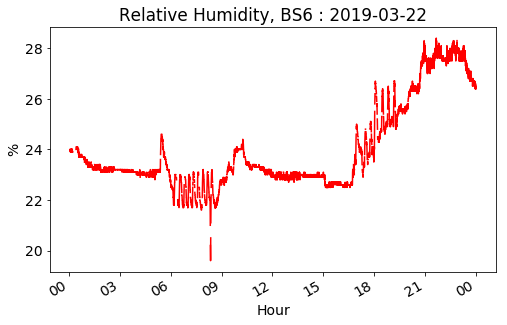

2019-03-23


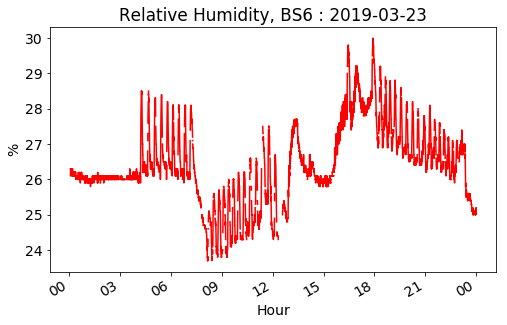

2019-03-24


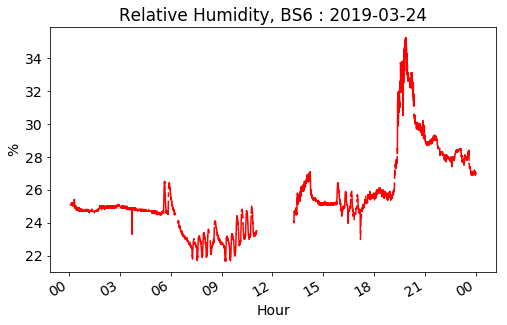

2019-03-25


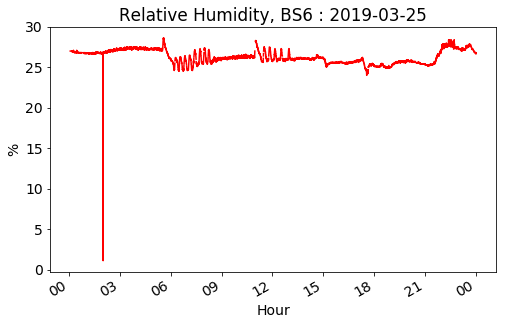

2019-03-26


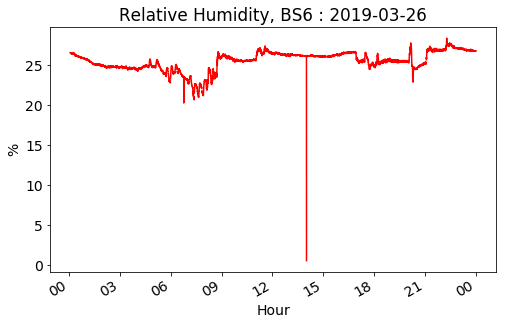

2019-03-27


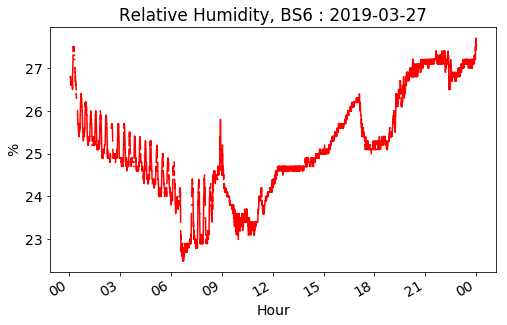

2019-03-28


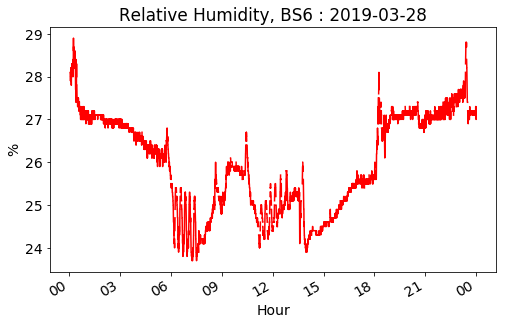

2019-03-29


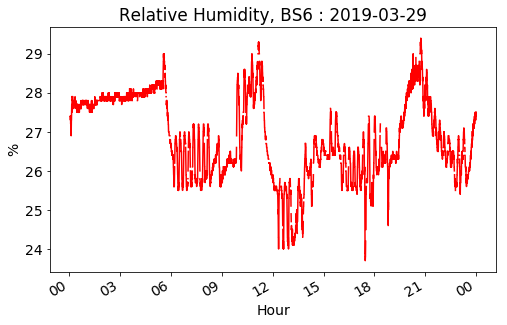

2019-03-30


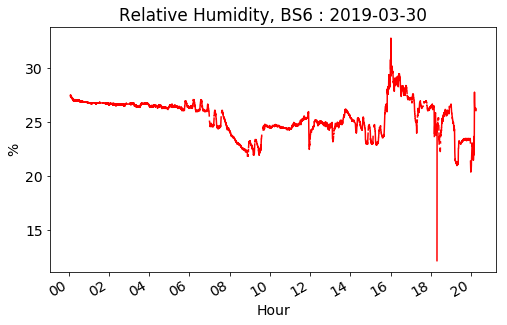

abs_humid
2019-02-23


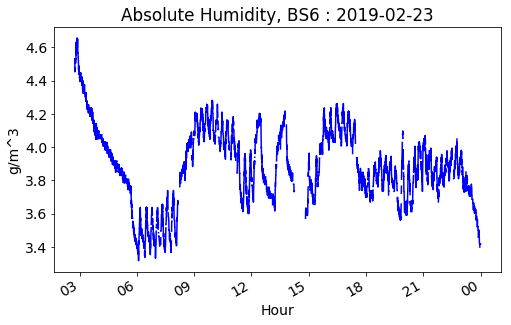

2019-02-24


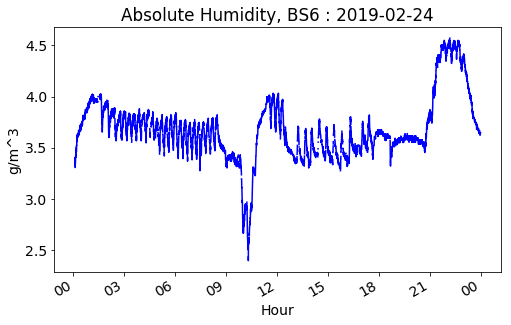

2019-02-25


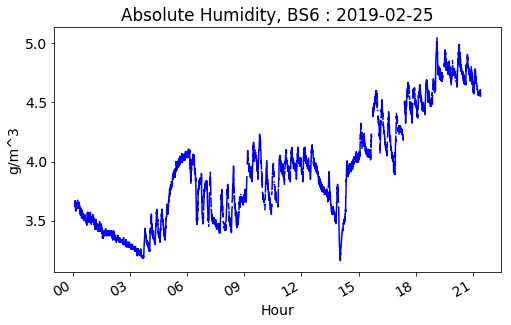

2019-02-26


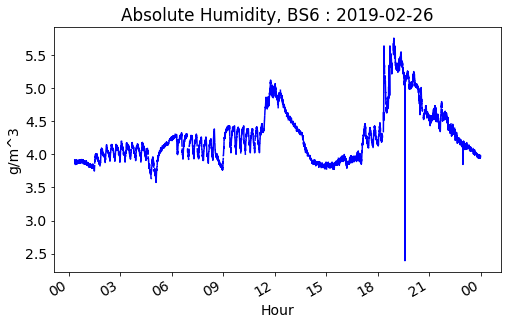

2019-02-27


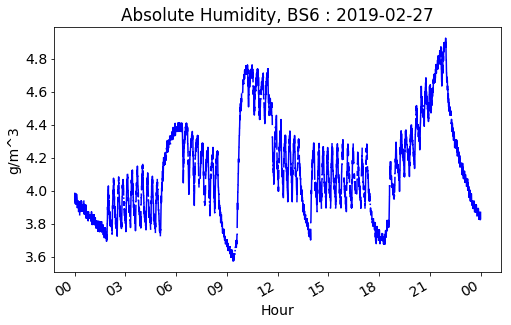

2019-02-28


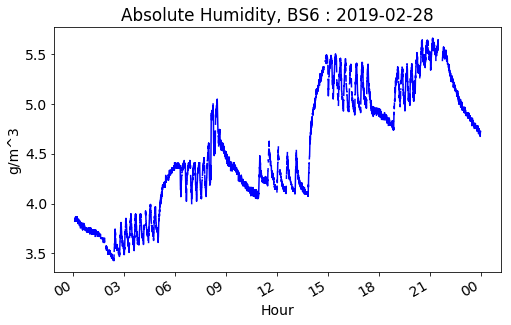

2019-03-01


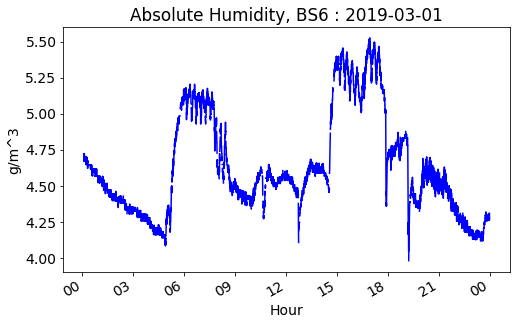

2019-03-02


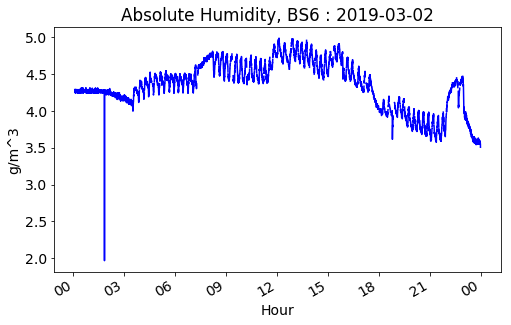

2019-03-03


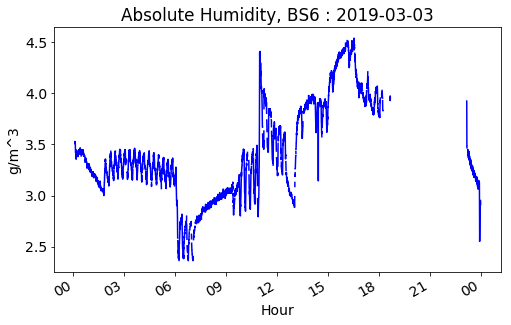

2019-03-04


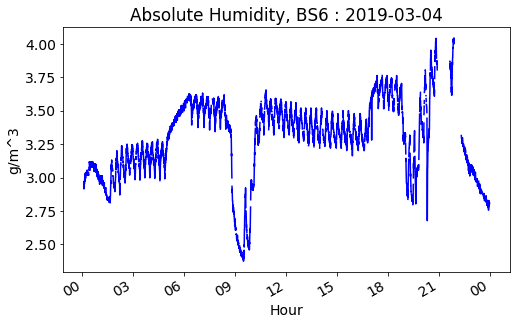

2019-03-05


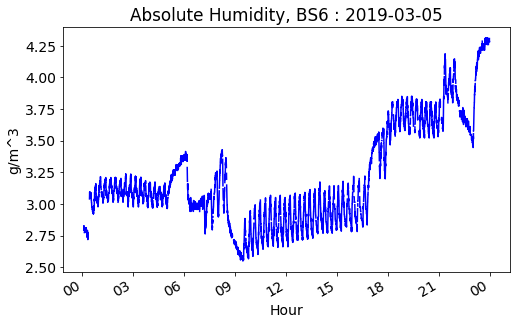

2019-03-06


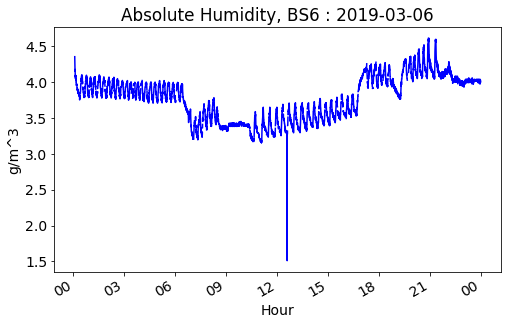

2019-03-07


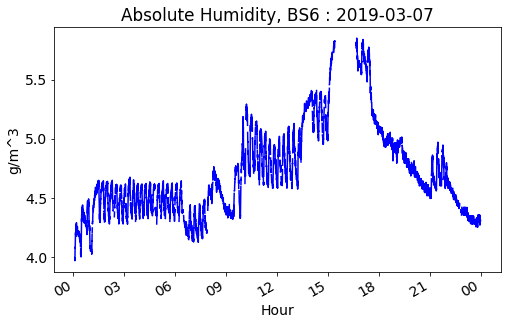

2019-03-08


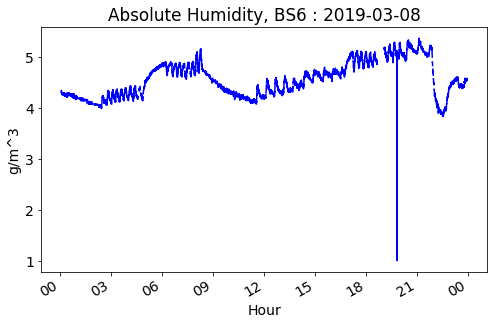

2019-03-09


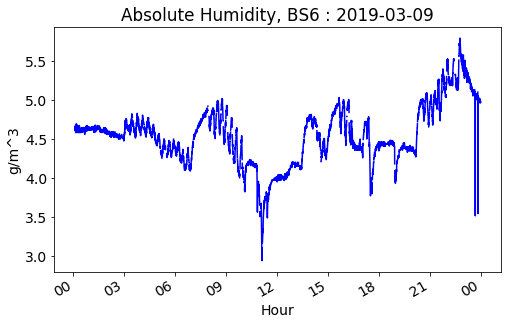

2019-03-10


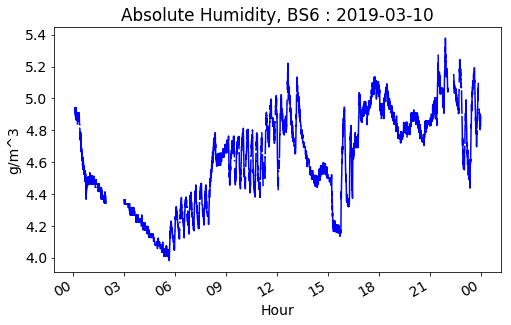

2019-03-11


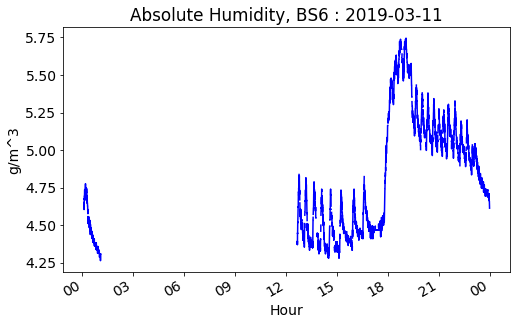

2019-03-12


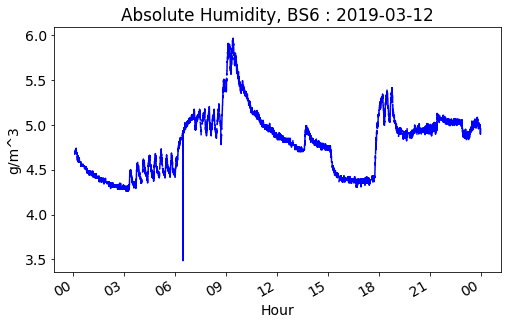

2019-03-13


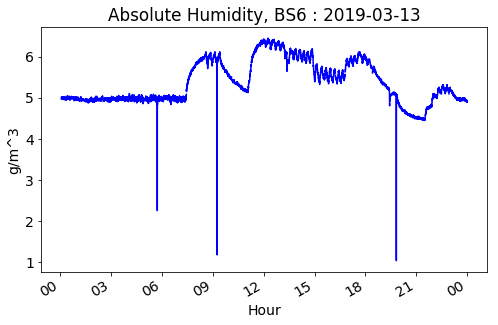

2019-03-14


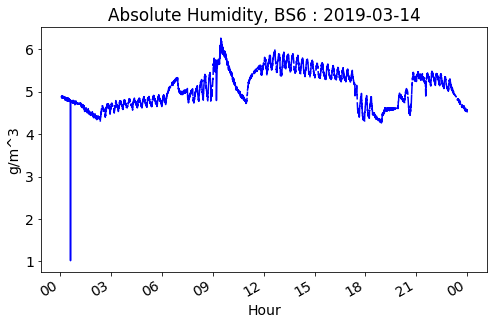

2019-03-15


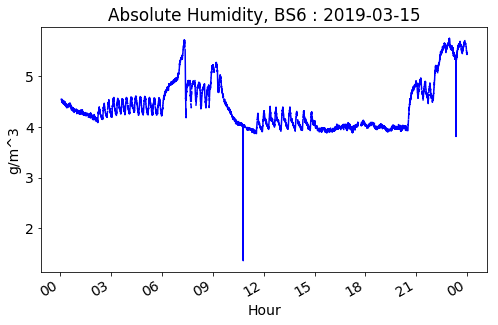

2019-03-16


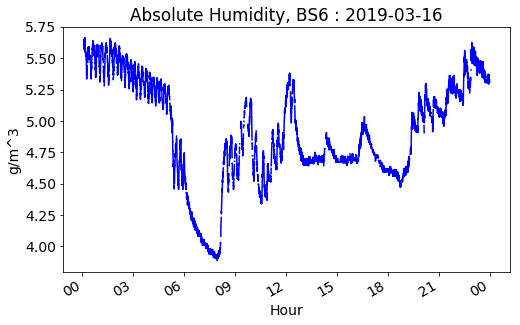

2019-03-17


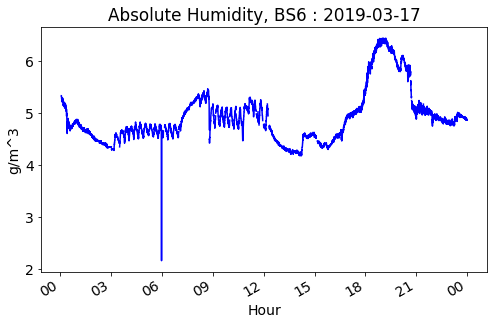

2019-03-18


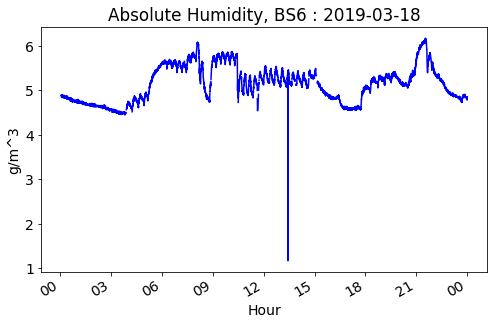

2019-03-19


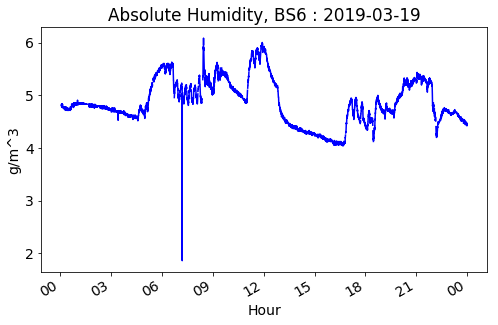

2019-03-20


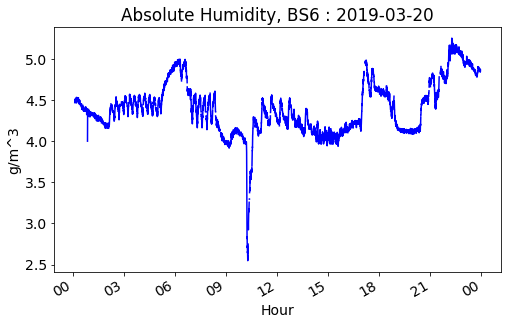

2019-03-21


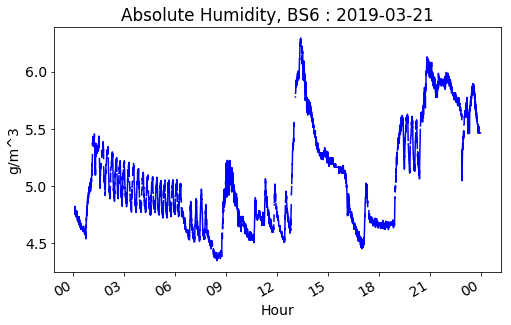

2019-03-22


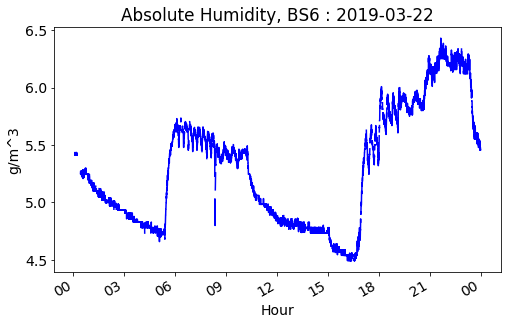

2019-03-23


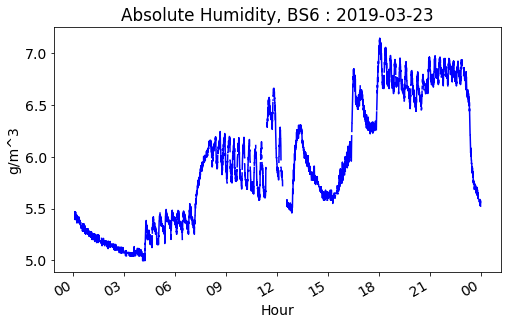

2019-03-24


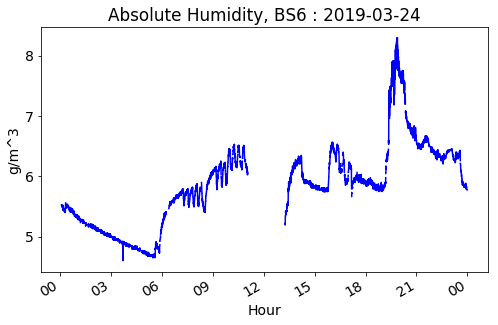

2019-03-25


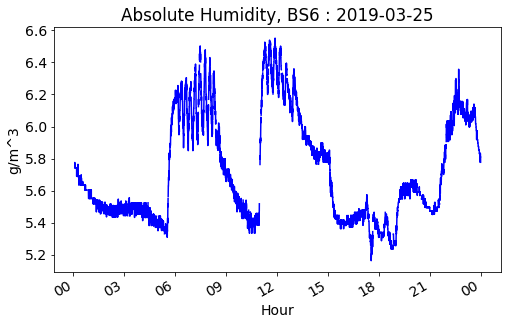

2019-03-26


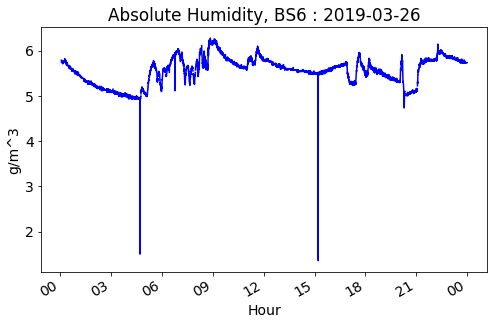

2019-03-27


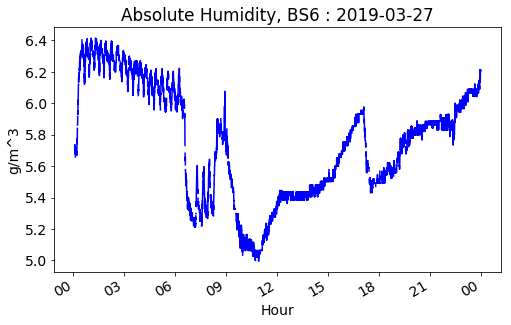

2019-03-28


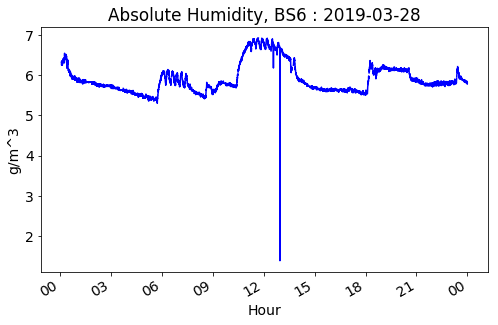

2019-03-29


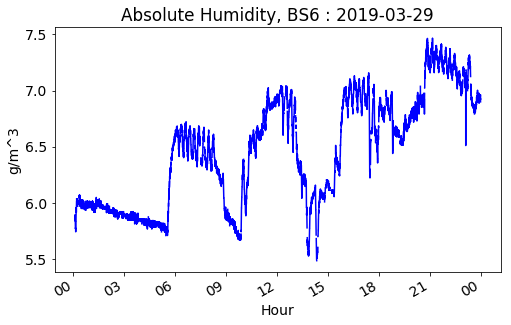

2019-03-30


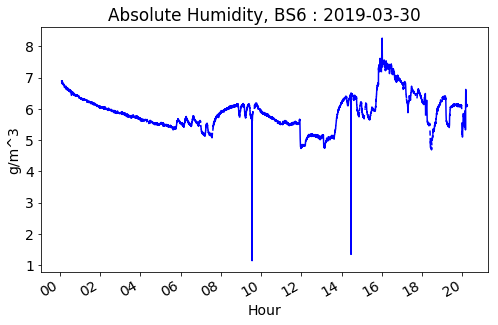

light_lux
2019-02-23


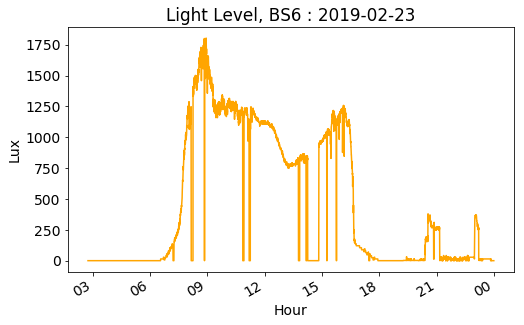

2019-02-24


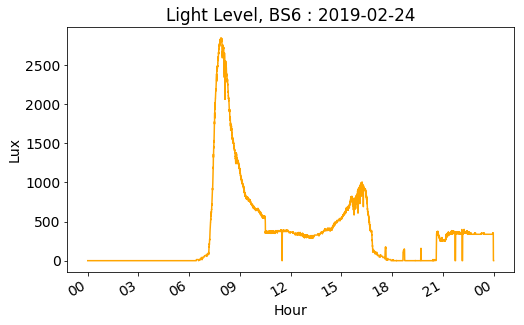

2019-02-25


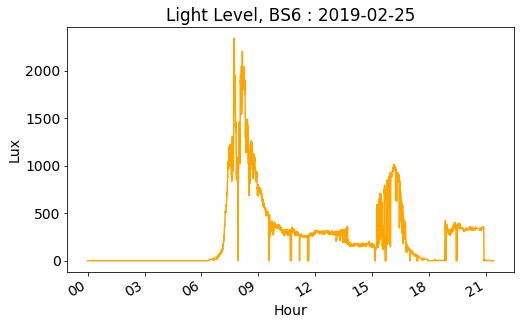

2019-02-26


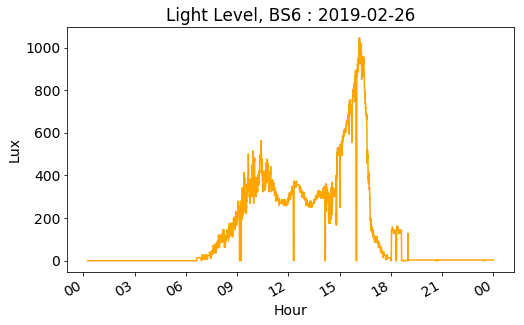

2019-02-27


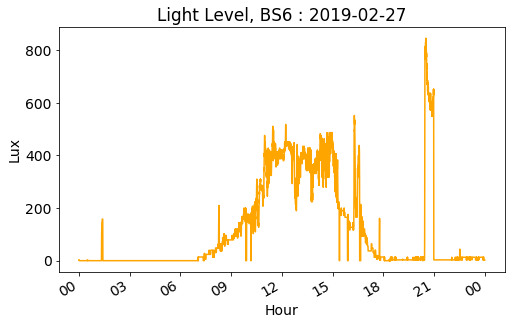

2019-02-28


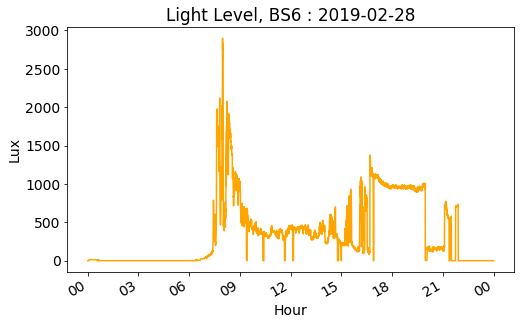

2019-03-01


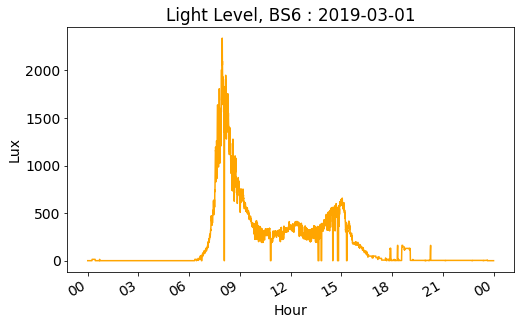

2019-03-02


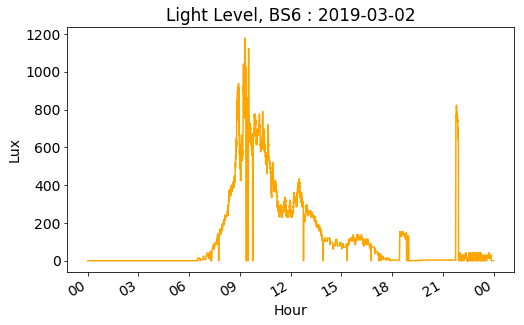

2019-03-03


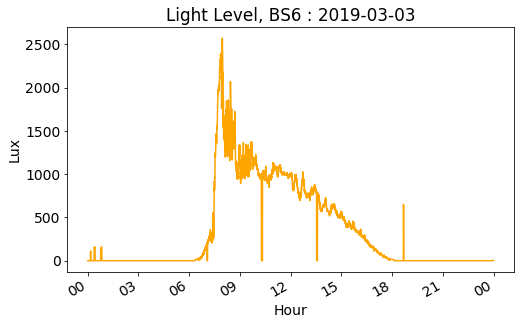

2019-03-04


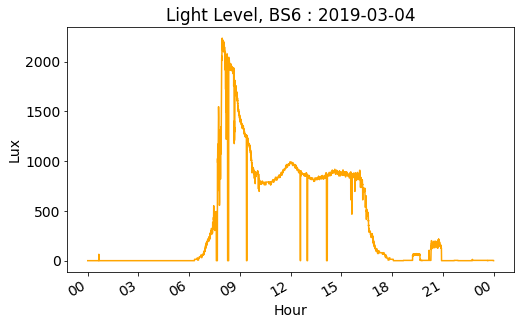

2019-03-05


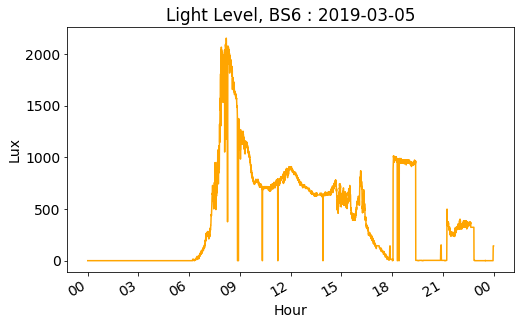

2019-03-06


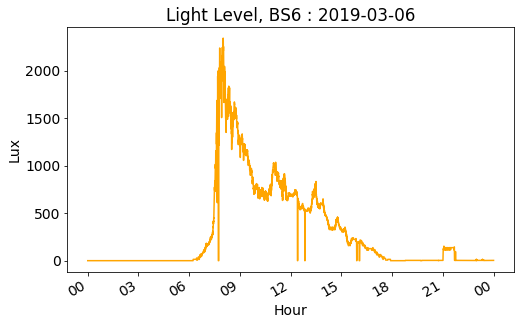

2019-03-07


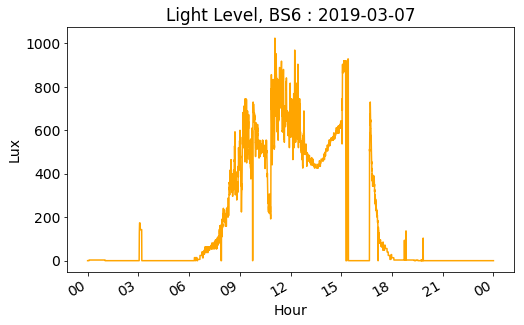

2019-03-08


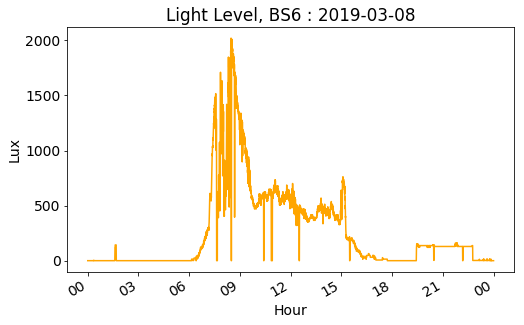

2019-03-09


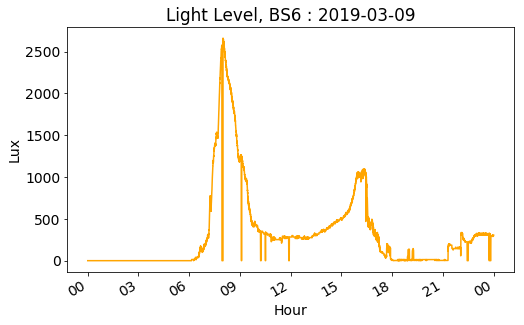

2019-03-10


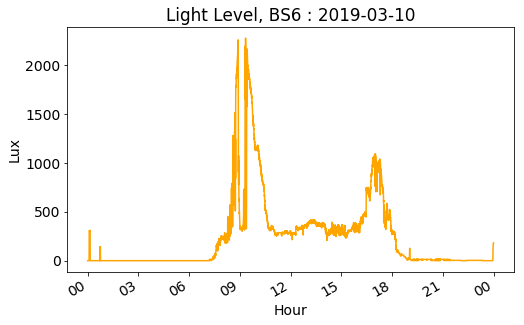

2019-03-11


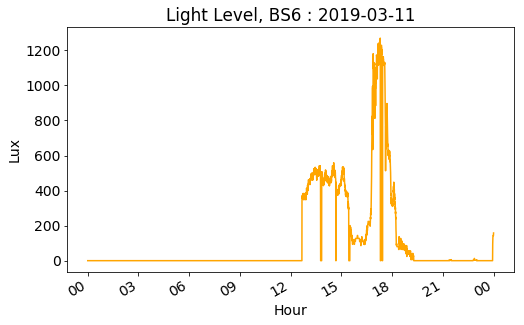

2019-03-12


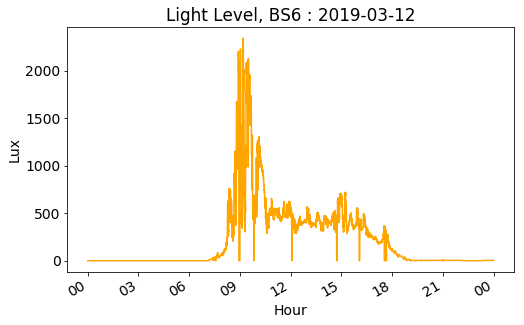

2019-03-13


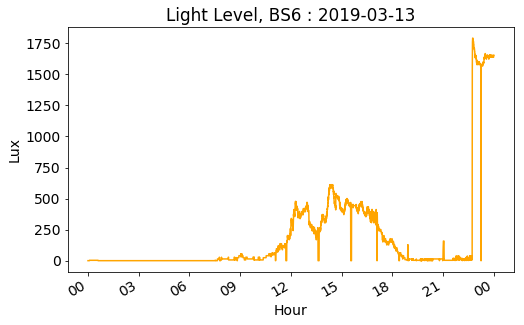

2019-03-14


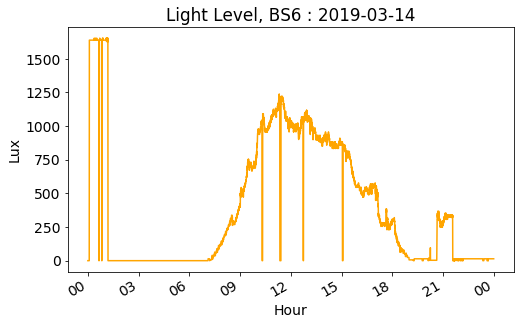

2019-03-15


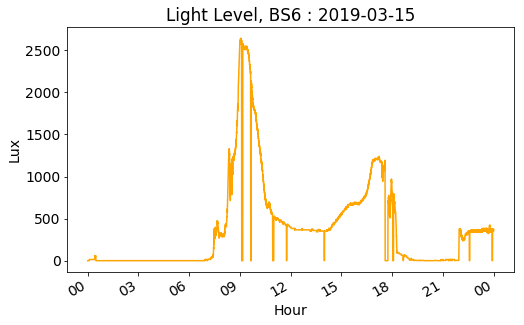

2019-03-16


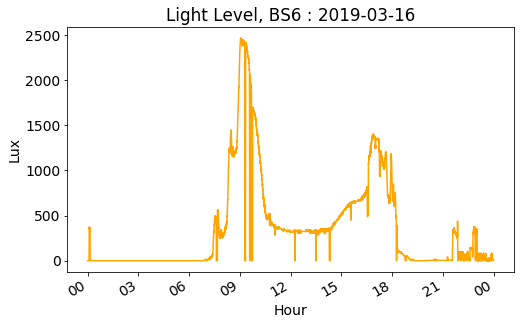

2019-03-17


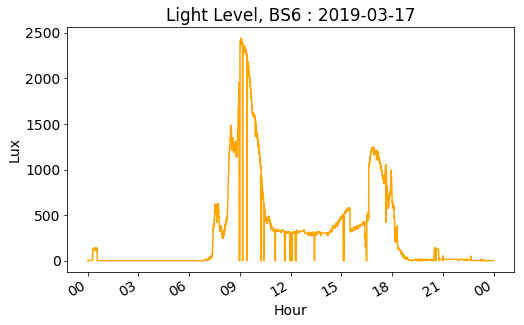

2019-03-18


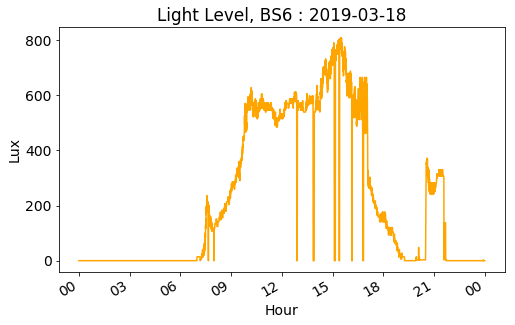

2019-03-19


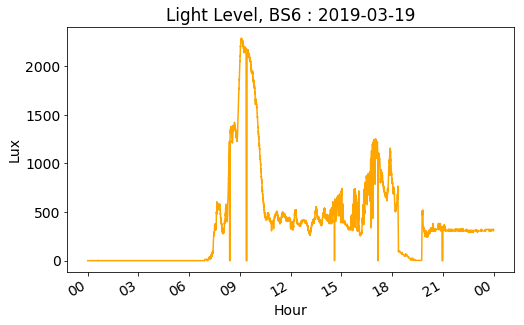

2019-03-20


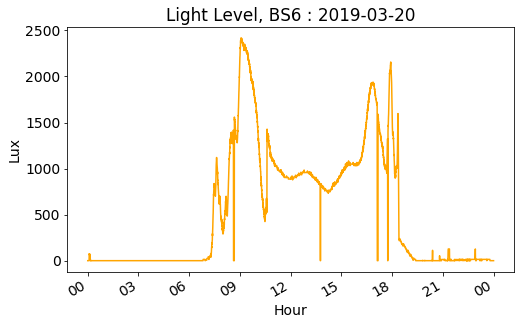

2019-03-21


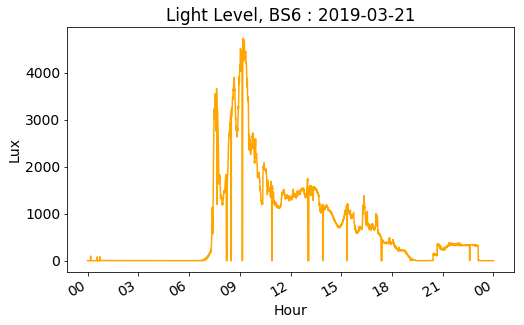

2019-03-22


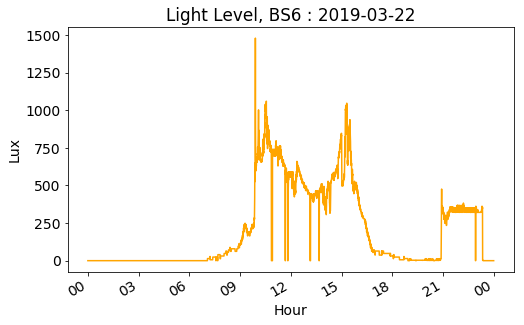

2019-03-23


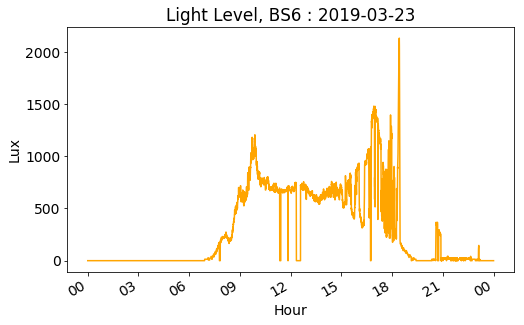

2019-03-24


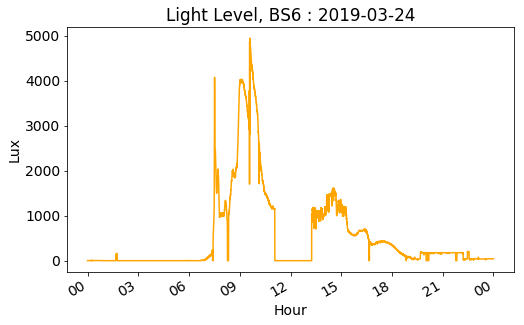

2019-03-25


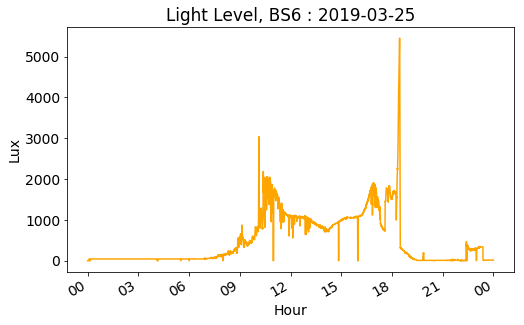

2019-03-26


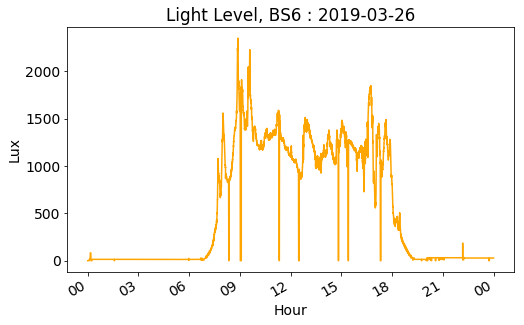

2019-03-27


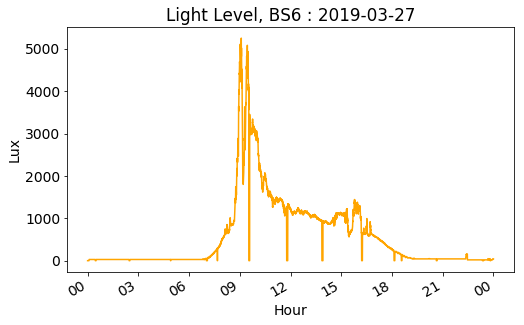

2019-03-28


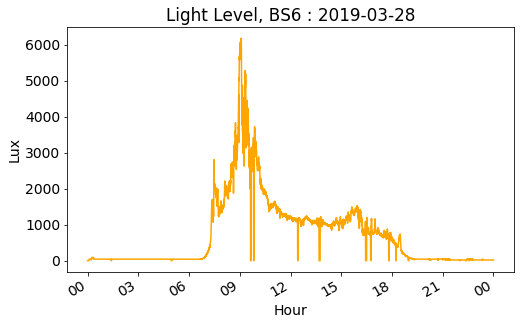

2019-03-29


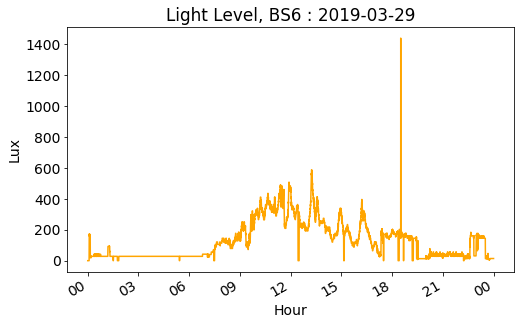

2019-03-30


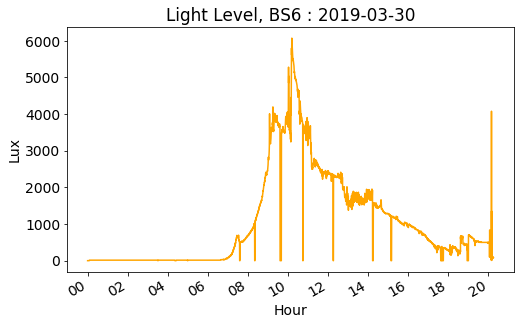

tvoc_ppb
2019-02-23


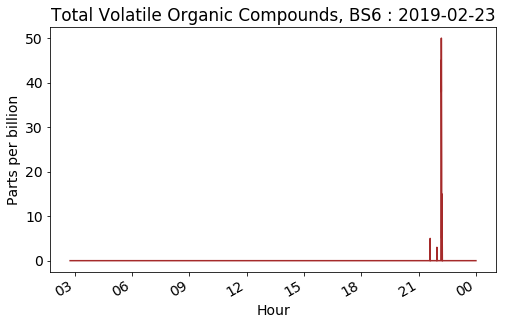

2019-02-24


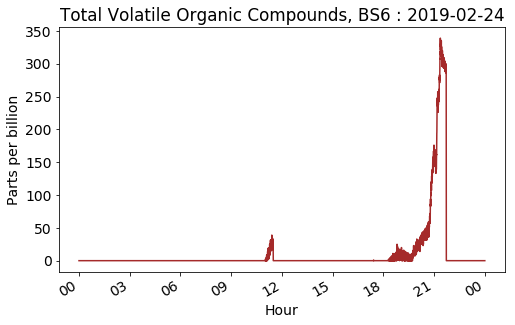

2019-02-25


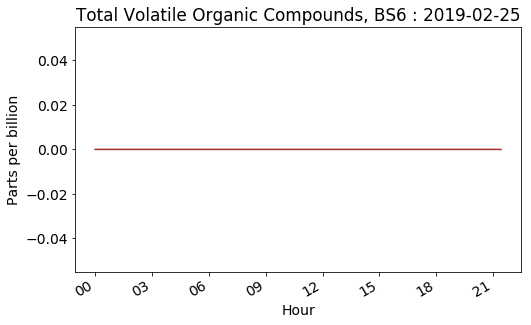

2019-02-26


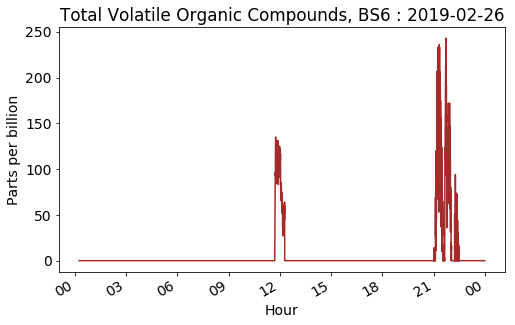

2019-02-27


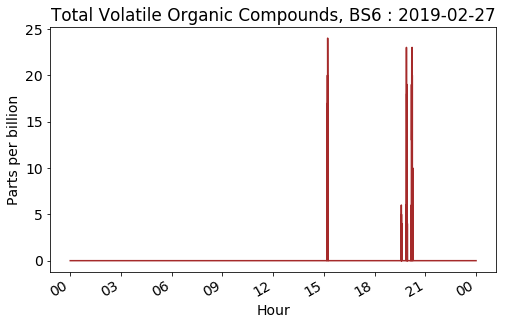

2019-02-28


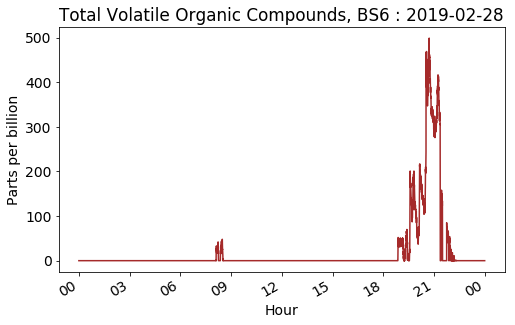

2019-03-01


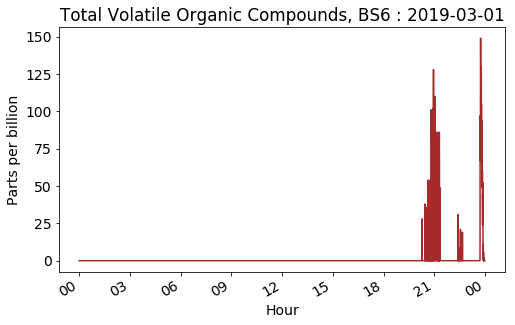

2019-03-02


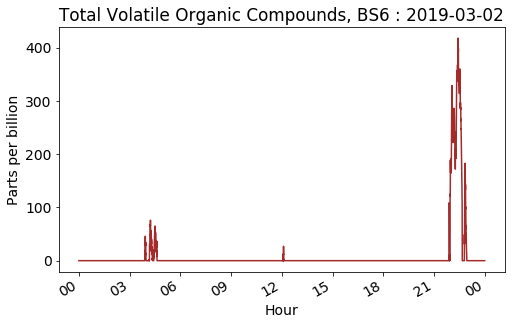

2019-03-03


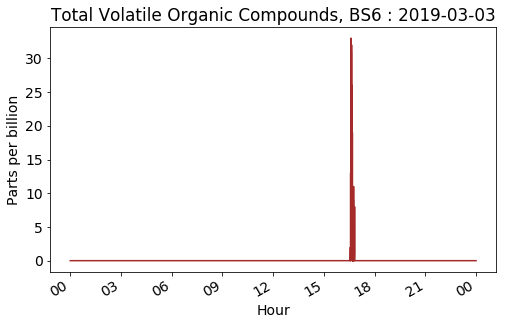

2019-03-04


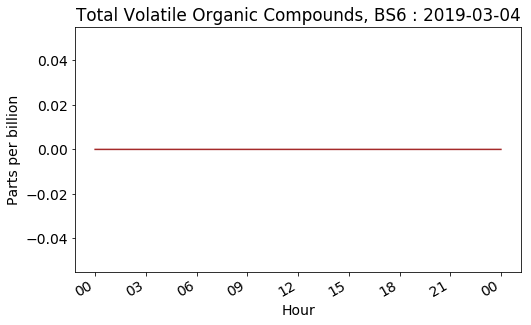

2019-03-05


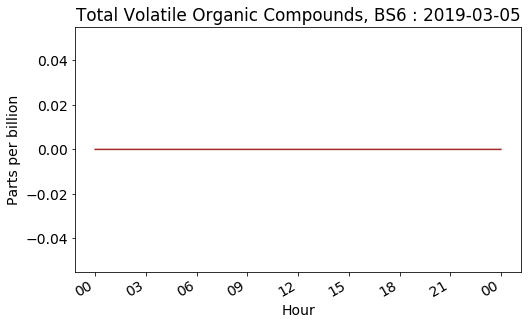

2019-03-06


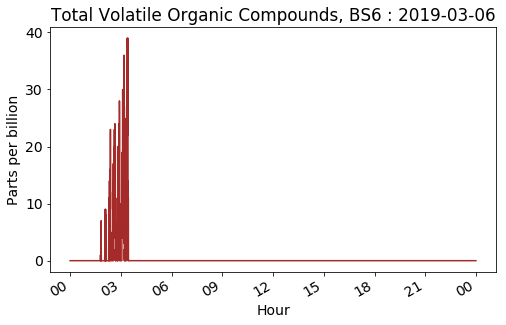

2019-03-07


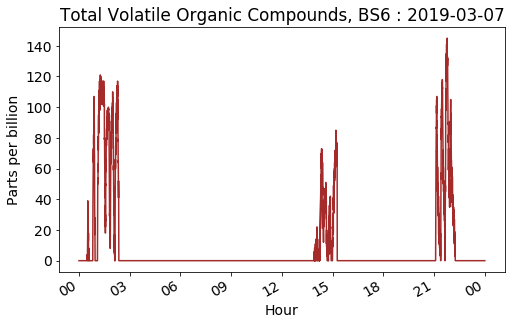

2019-03-08


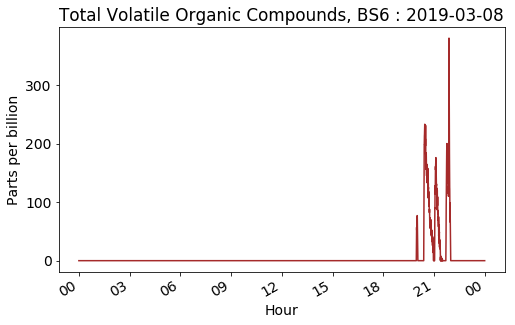

2019-03-09


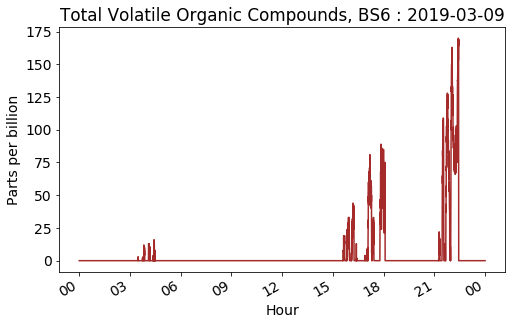

2019-03-10


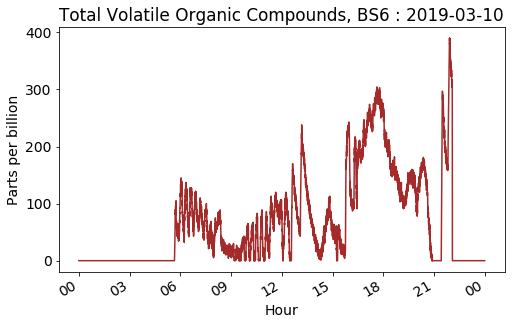

2019-03-11


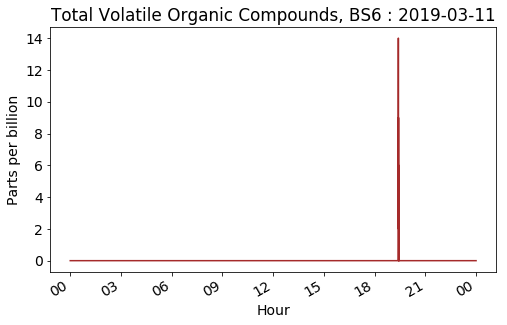

2019-03-12


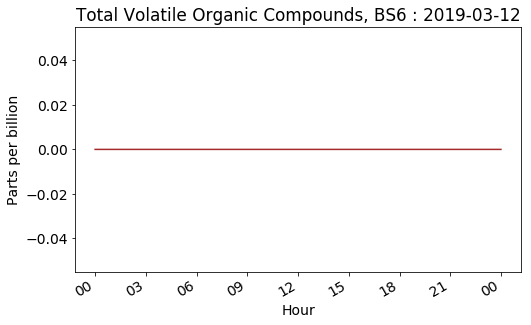

2019-03-13


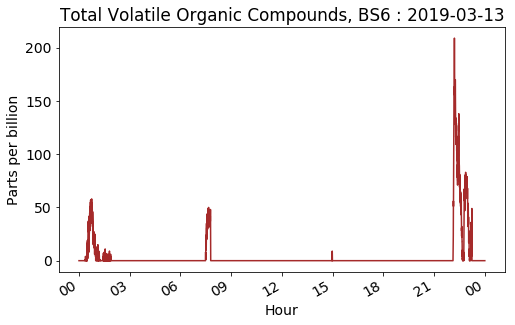

2019-03-14


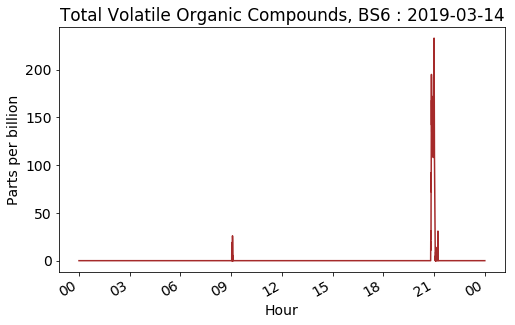

2019-03-15


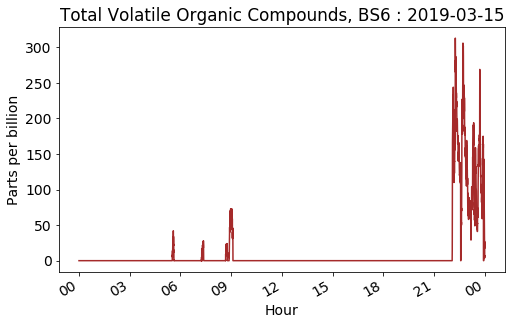

2019-03-16


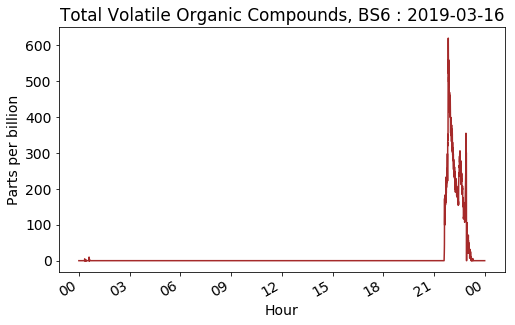

2019-03-17


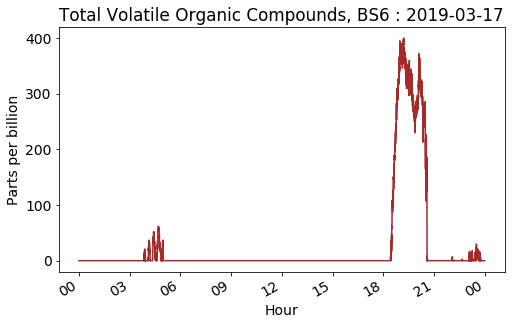

2019-03-18


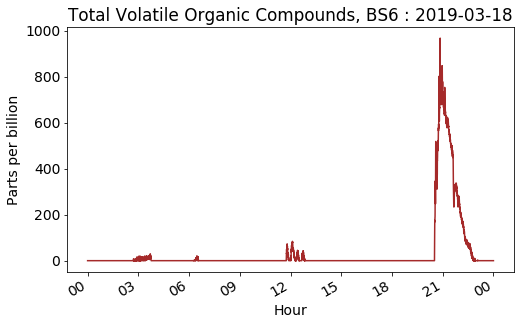

2019-03-19


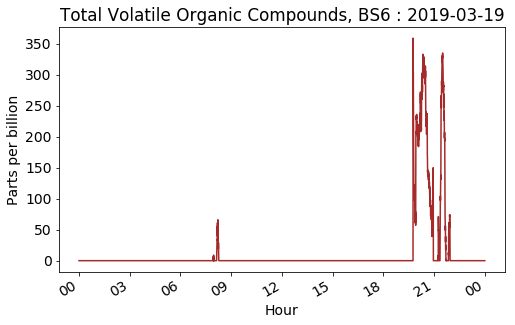

2019-03-20


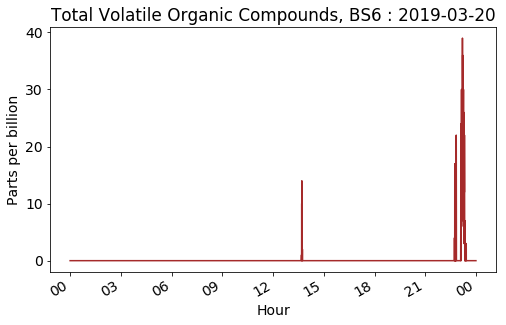

2019-03-21


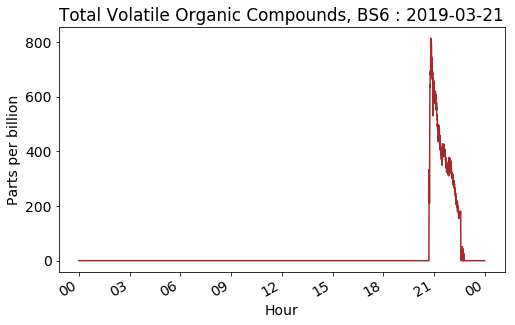

2019-03-22


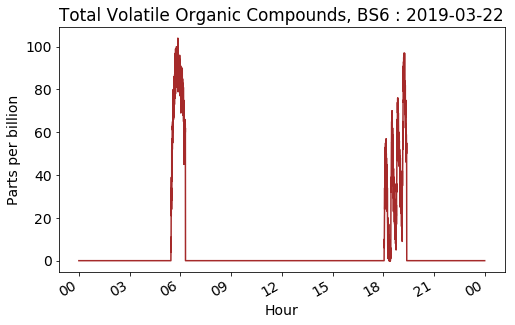

2019-03-23


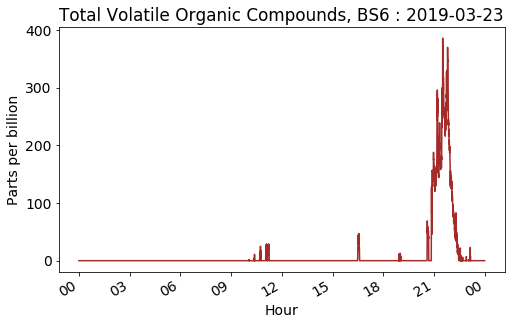

2019-03-24


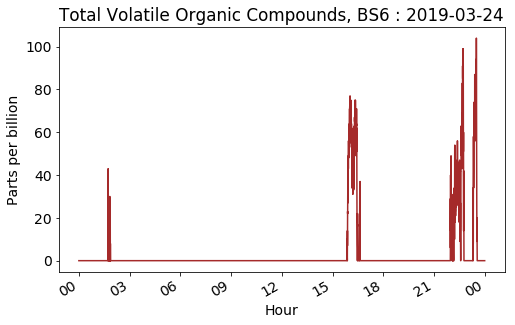

2019-03-25


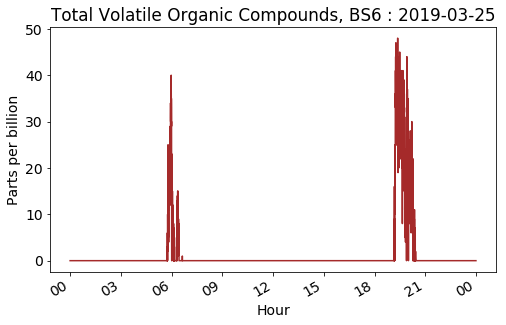

2019-03-26


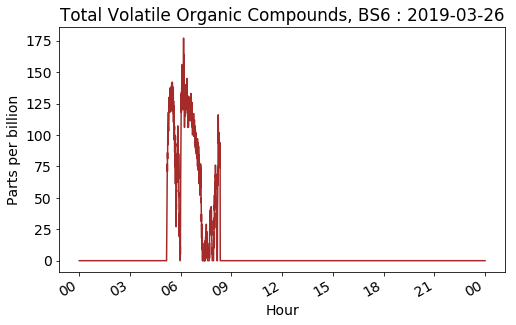

2019-03-27


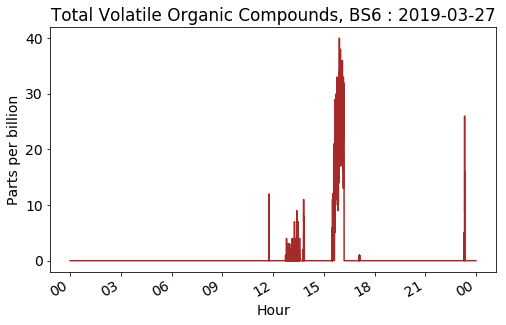

2019-03-28


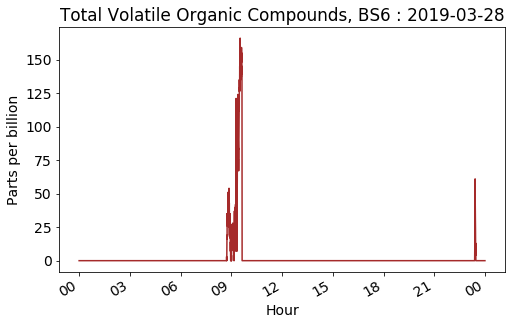

2019-03-29


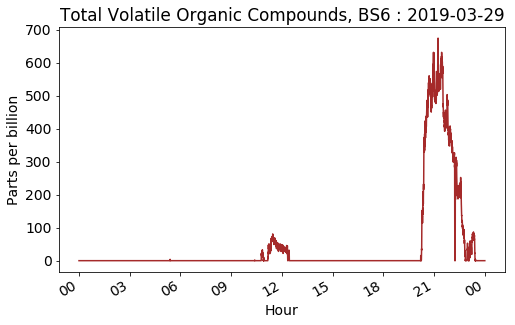

2019-03-30


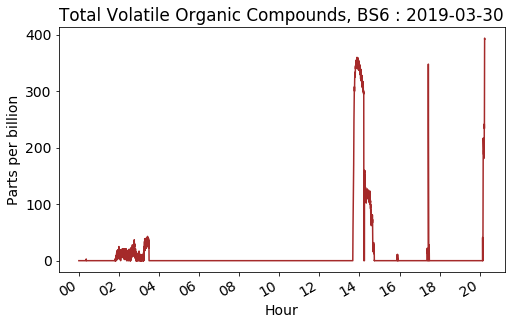

co2eq_ppm
2019-02-23


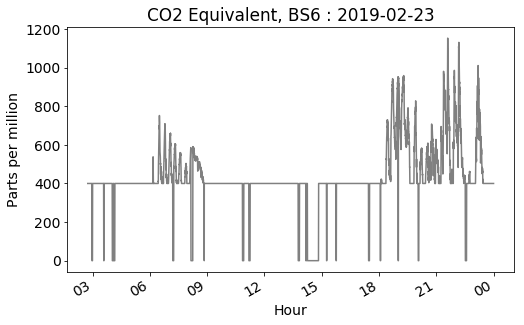

2019-02-24


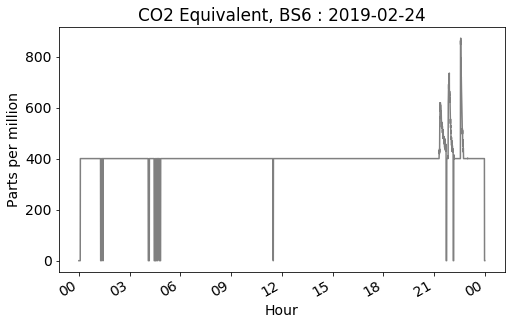

2019-02-25


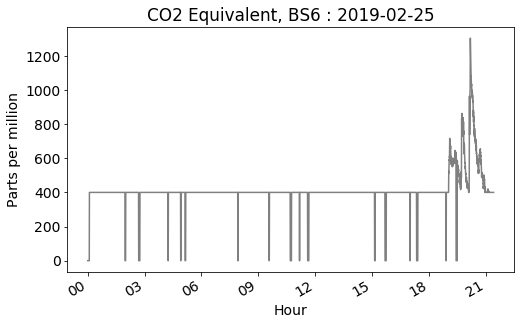

2019-02-26


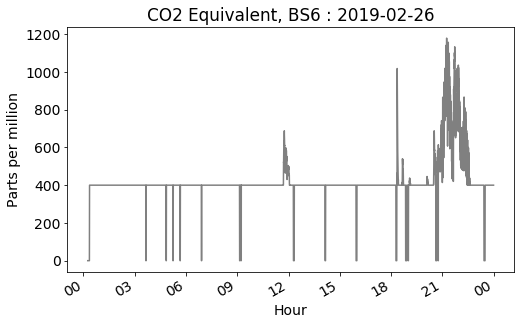

2019-02-27


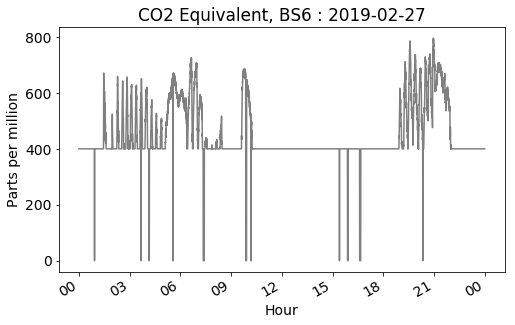

2019-02-28


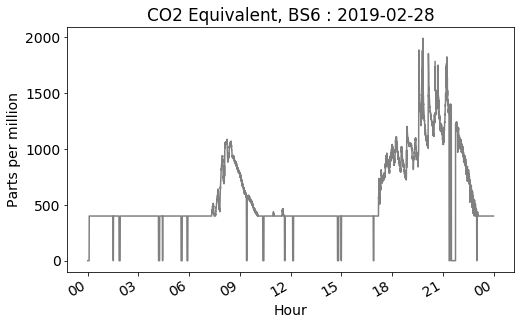

2019-03-01


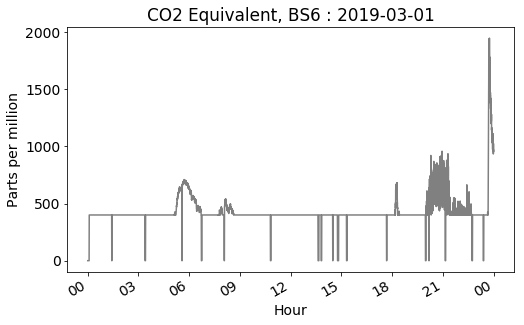

2019-03-02


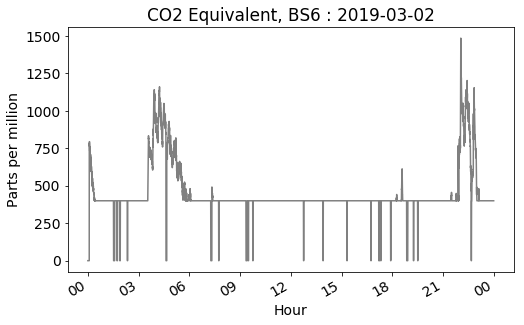

2019-03-03


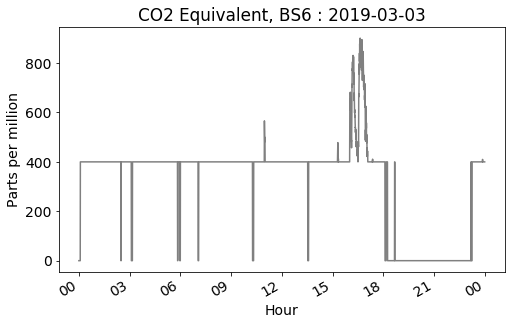

2019-03-04


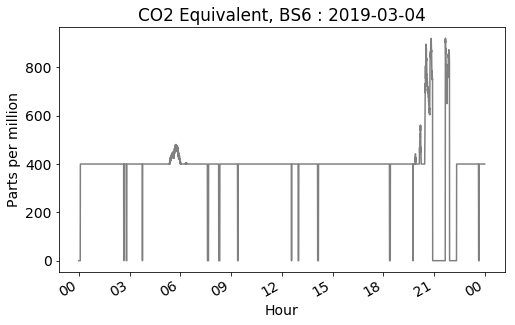

2019-03-05


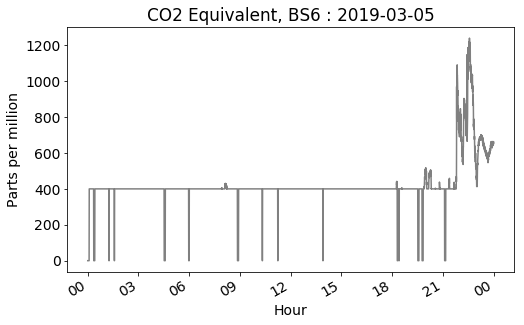

2019-03-06


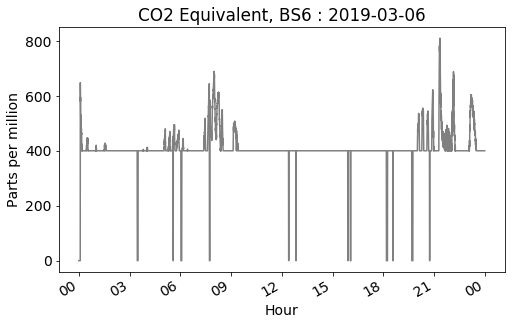

2019-03-07


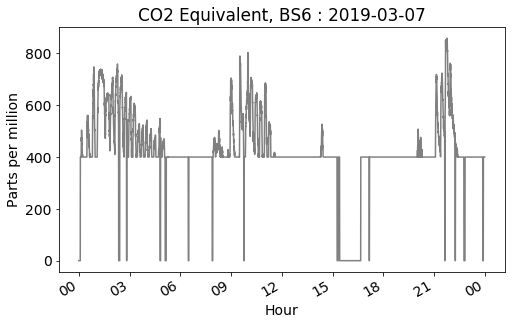

2019-03-08


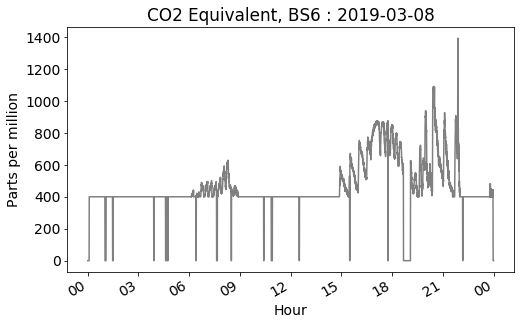

2019-03-09


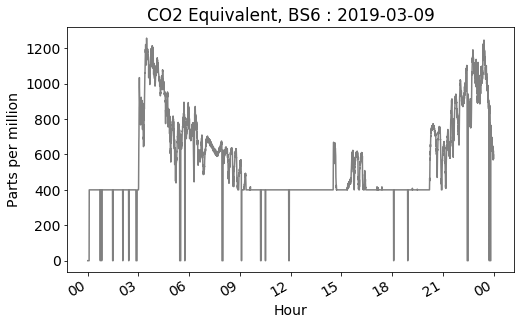

2019-03-10


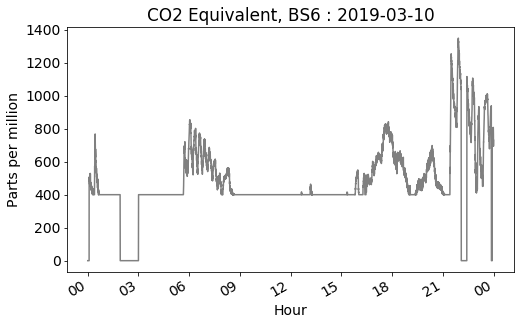

2019-03-11


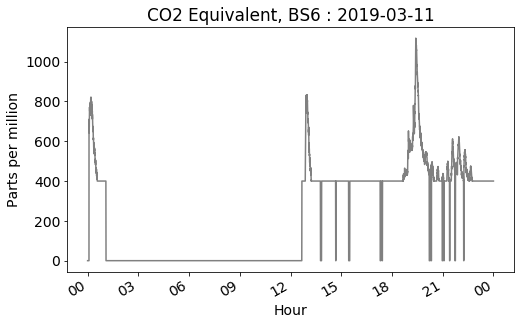

2019-03-12


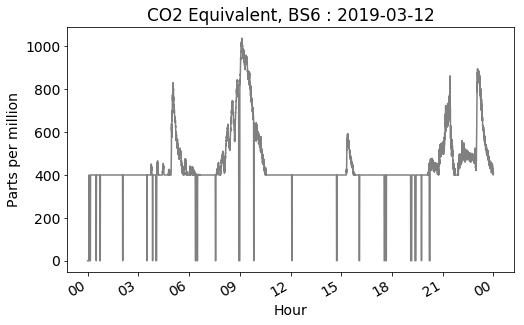

2019-03-13


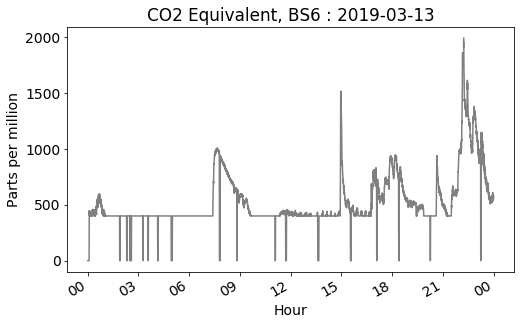

2019-03-14


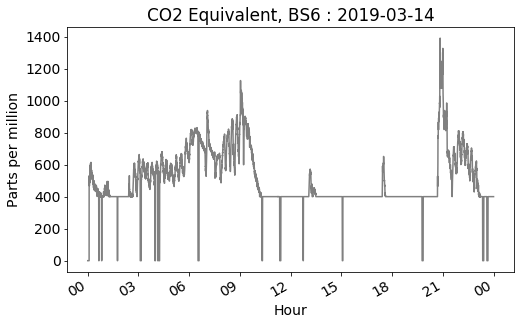

2019-03-15


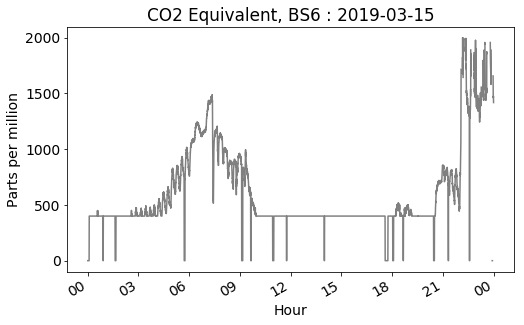

2019-03-16


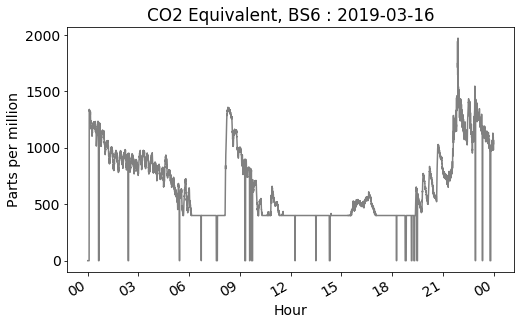

2019-03-17


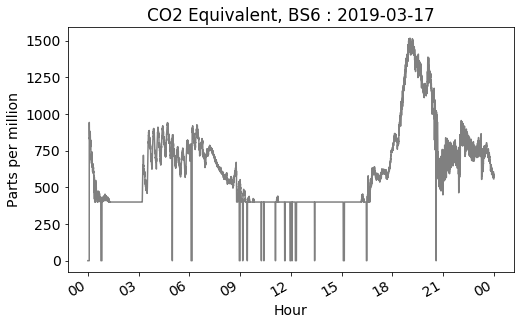

2019-03-18


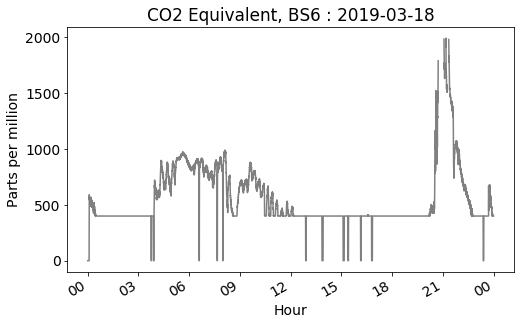

2019-03-19


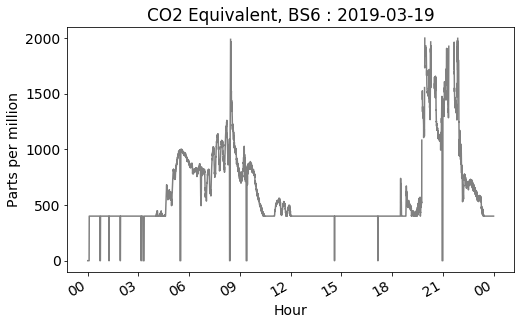

2019-03-20


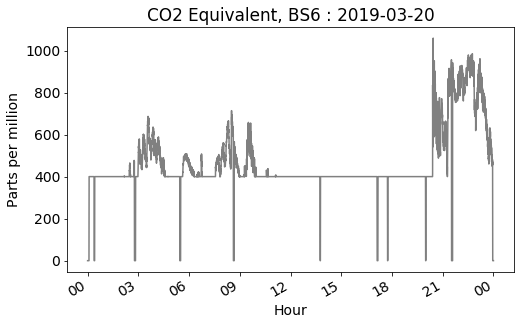

2019-03-21


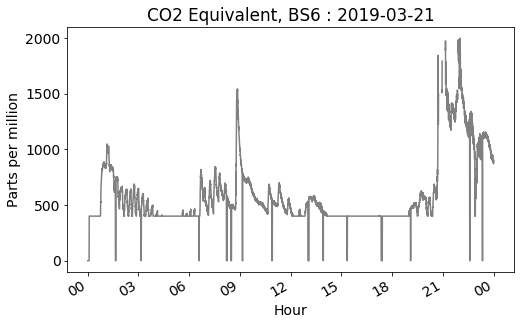

2019-03-22


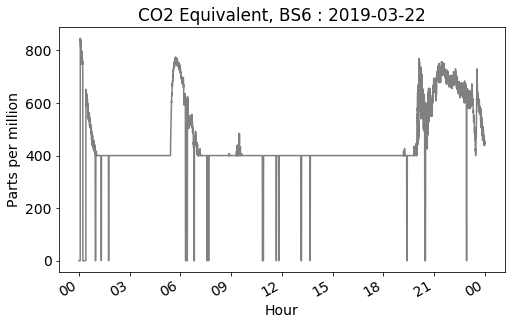

2019-03-23


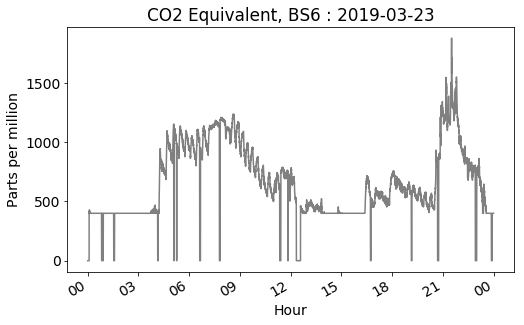

2019-03-24


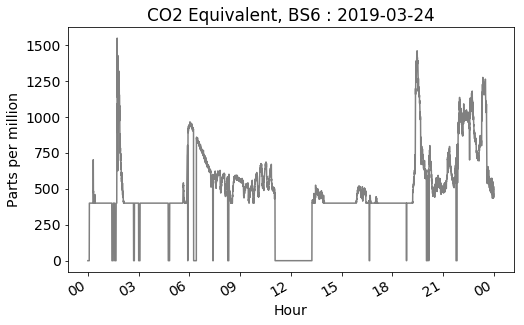

2019-03-25


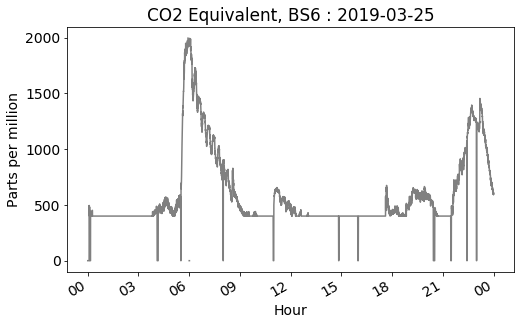

2019-03-26


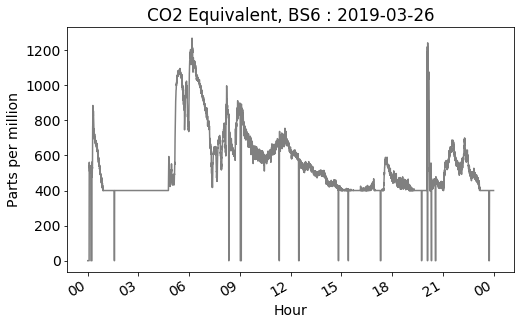

2019-03-27


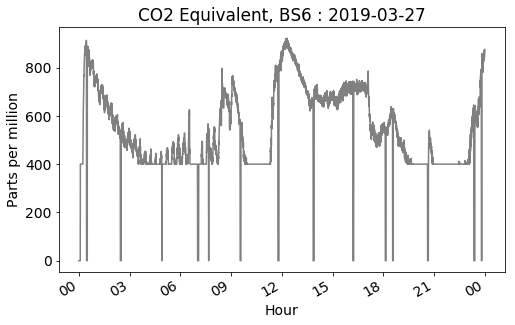

2019-03-28


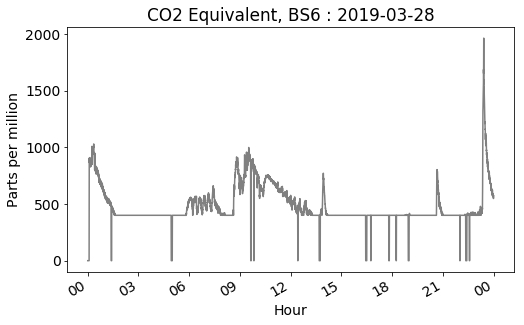

2019-03-29


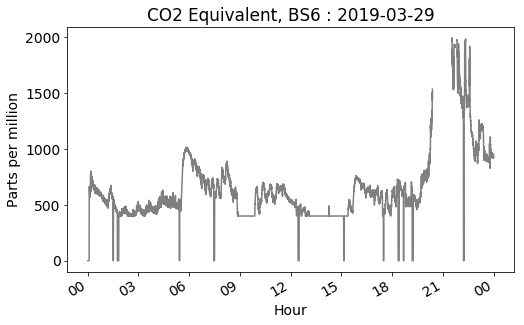

2019-03-30


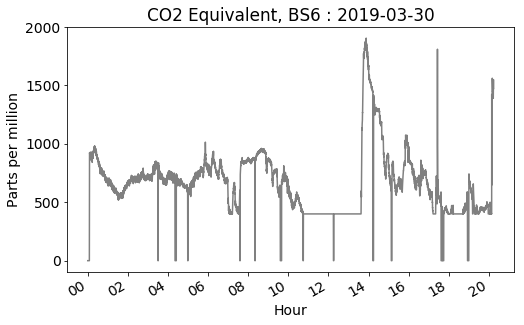

dist_mm
2019-02-23


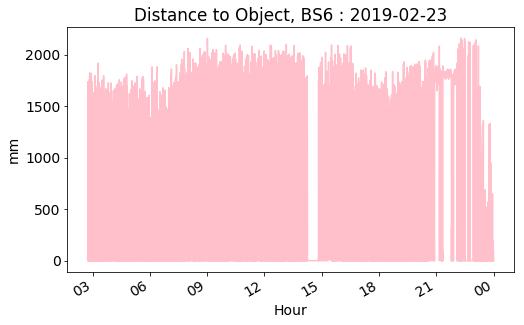

2019-02-24


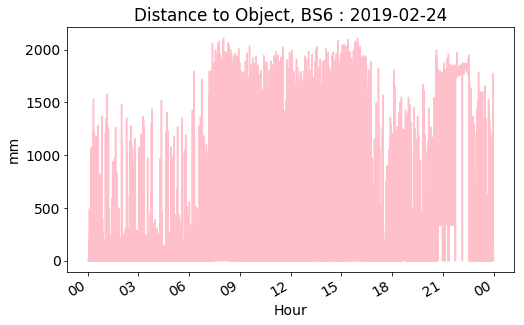

2019-02-25


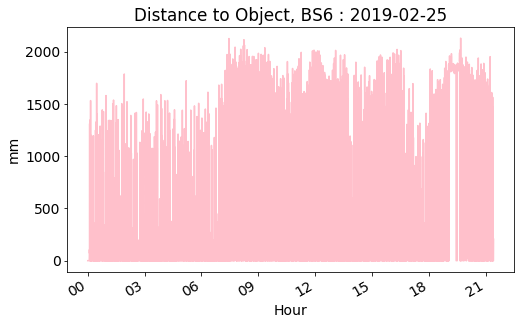

2019-02-26


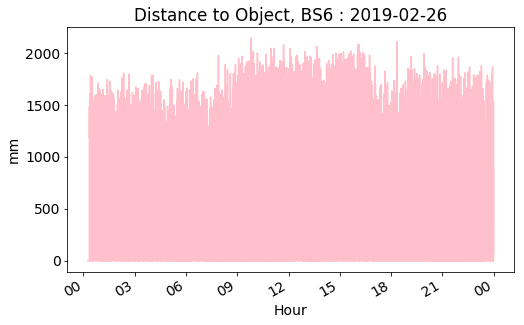

2019-02-27


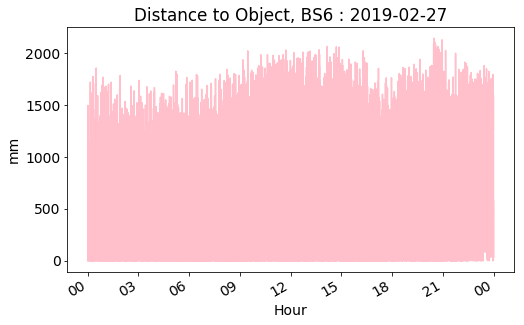

2019-02-28


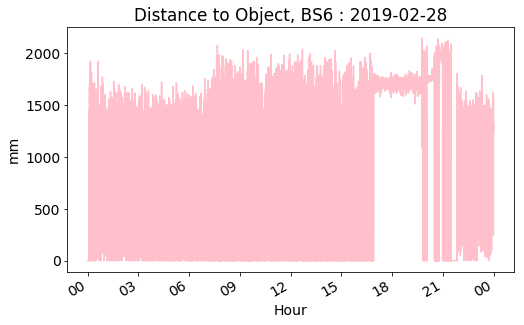

2019-03-01


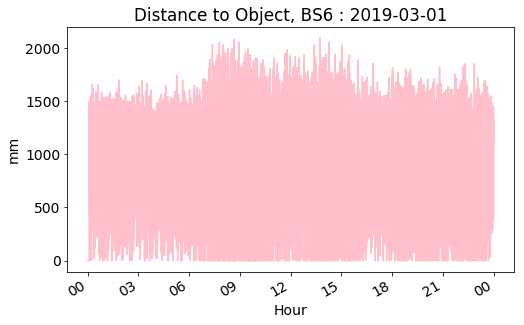

2019-03-02


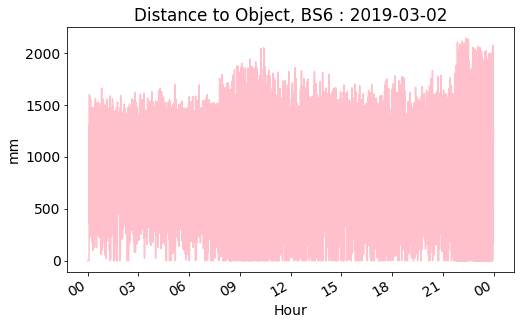

2019-03-03


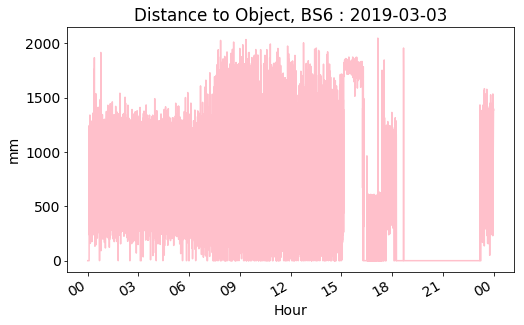

2019-03-04


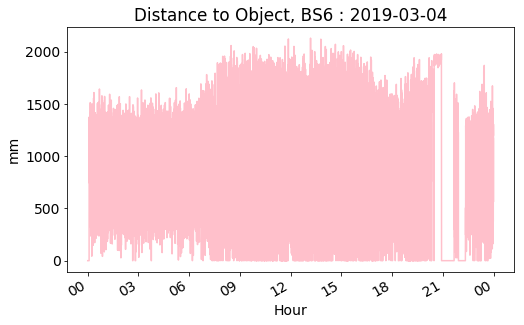

2019-03-05


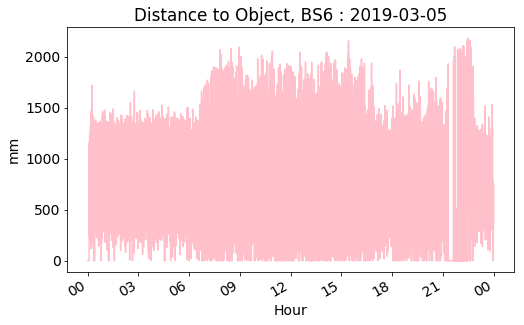

2019-03-06


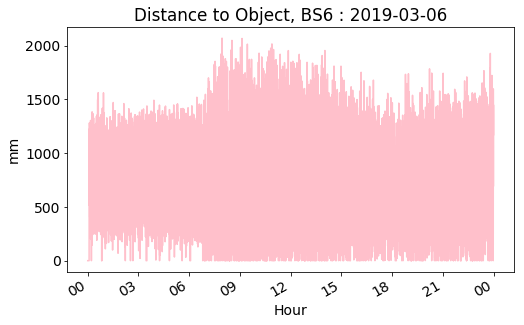

2019-03-07


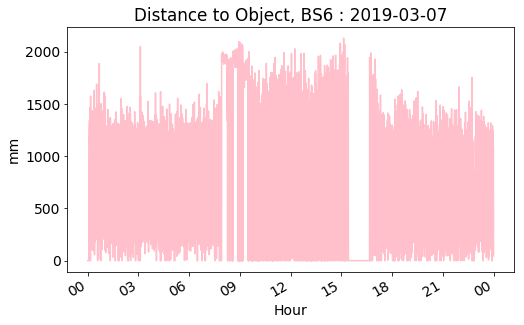

2019-03-08


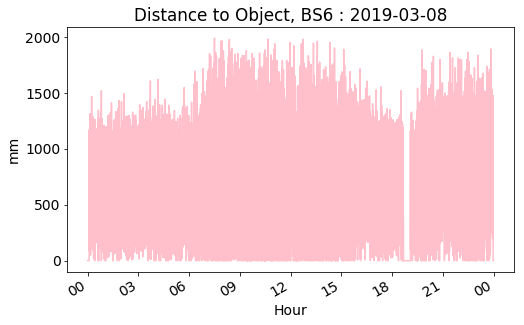

2019-03-09


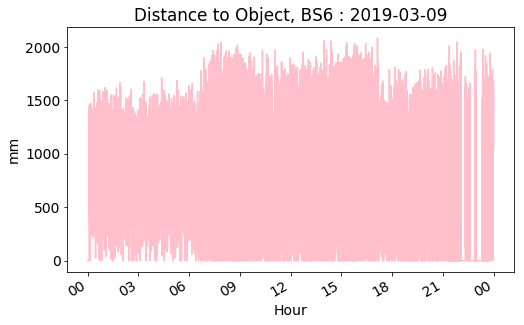

2019-03-10


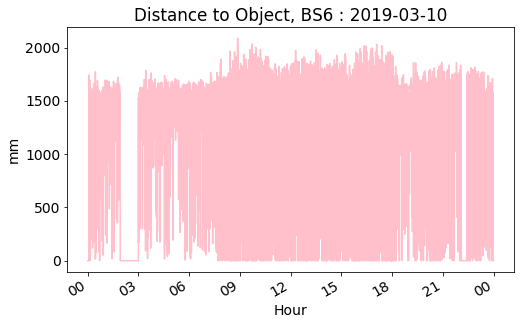

2019-03-11


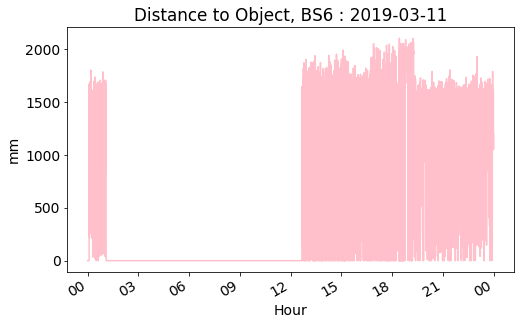

2019-03-12


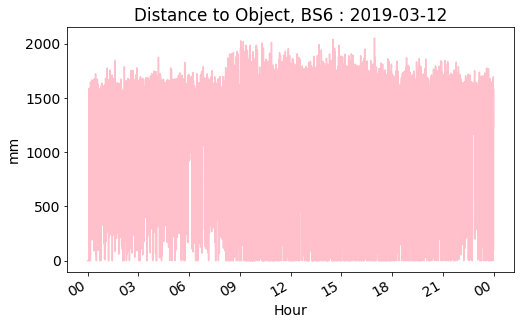

2019-03-13


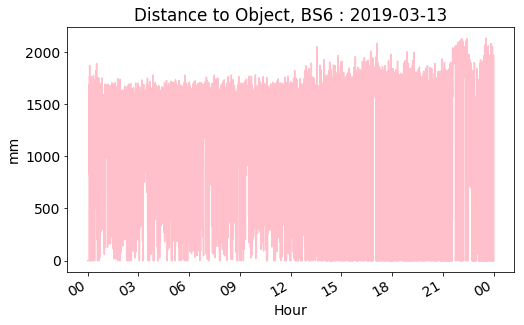

2019-03-14


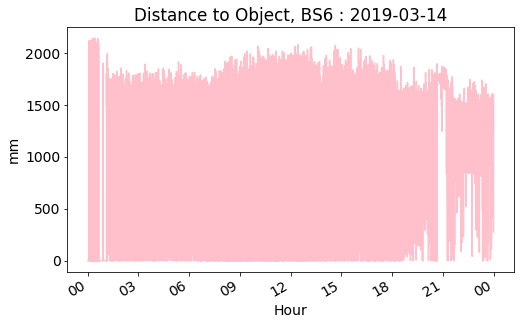

2019-03-15


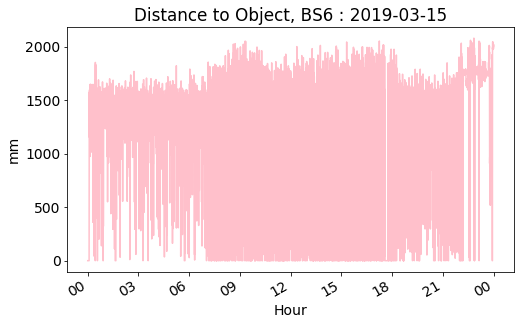

2019-03-16


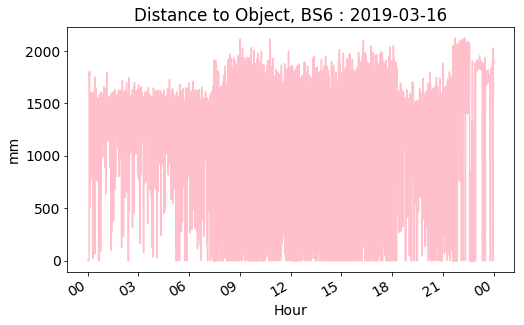

2019-03-17


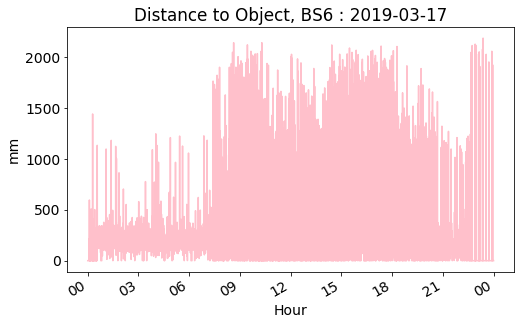

2019-03-18


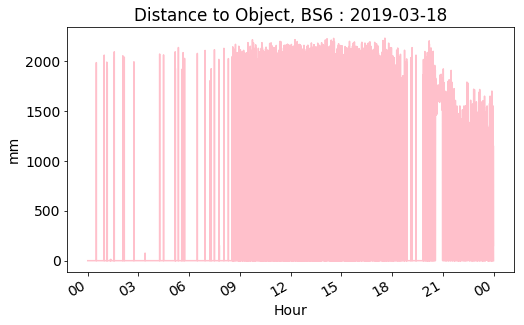

2019-03-19


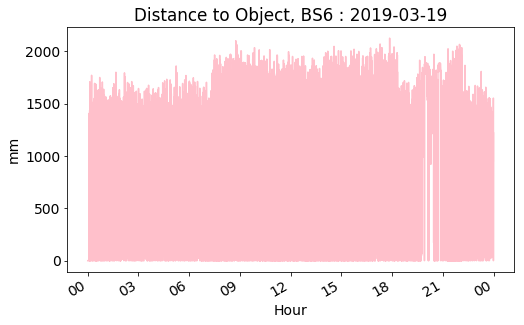

2019-03-20


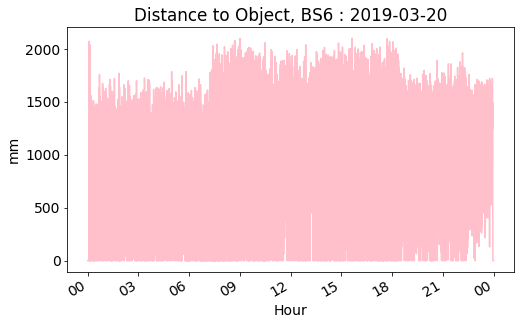

2019-03-21


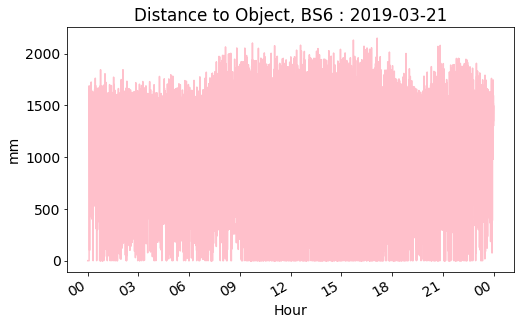

2019-03-22


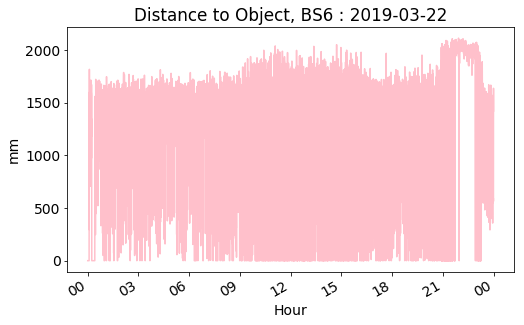

2019-03-23


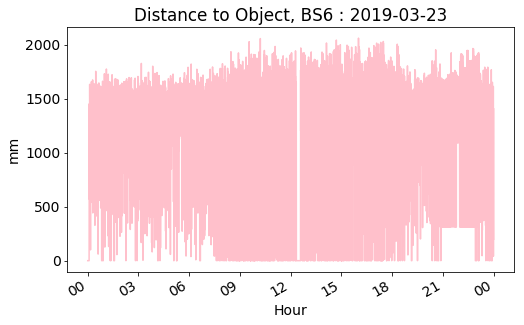

2019-03-24


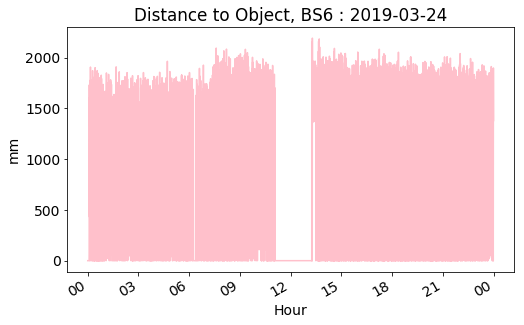

2019-03-25


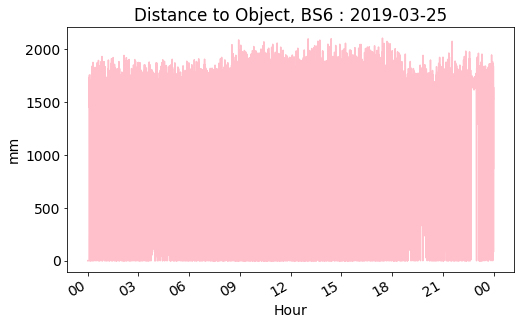

2019-03-26


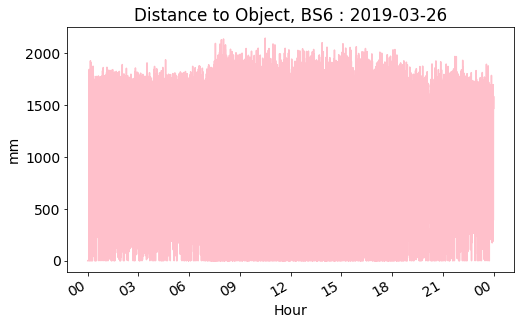

2019-03-27


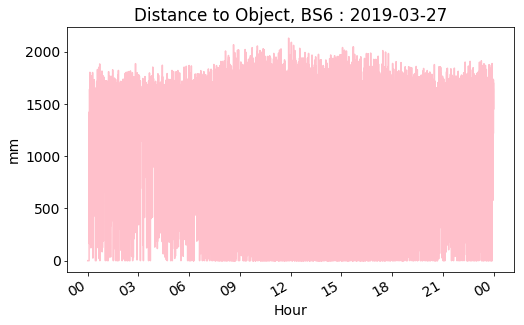

2019-03-28


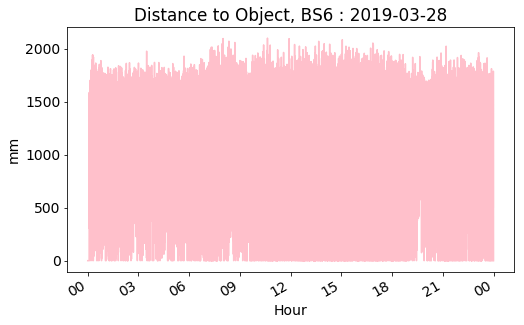

2019-03-29


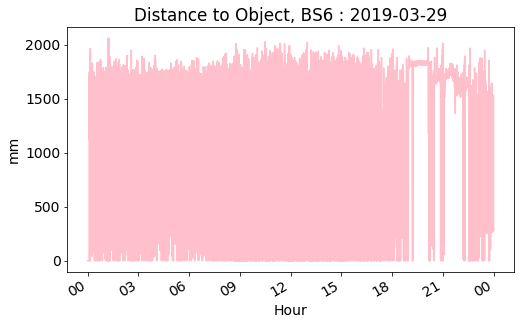

2019-03-30


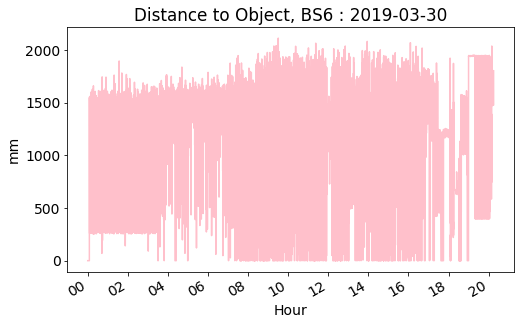

In [169]:
measures_to_plot = ['temp_c', 'rh_percent','abs_humid','light_lux','tvoc_ppb','co2eq_ppm','dist_mm']

units = {'temp_c':'Degree C', 'rh_percent':'%','abs_humid':'g/m^3' ,'light_lux':'Lux',
         'tvoc_ppb':'Parts per billion','co2eq_ppm':'Parts per million','dist_mm':'mm'}

names = {'temp_c': 'Temperature', 'rh_percent': 'Relative Humidity','abs_humid': 'Absolute Humidity','light_lux': 'Light Level',
         'tvoc_ppb': 'Total Volatile Organic Compounds','co2eq_ppm': 'CO2 Equivalent','dist_mm': 'Distance to Object'}


#measures_to_plot = ['temp_c']
max_min = {'temp_c': [20, 30], 'rh_percent': [0,40], 'tvoc_ppb':[0,2000], 'co2eq_ppm':[0,2000],'abs_humid': [1,10]}

colors = ['green', 'red', 'blue', 'orange', 'brown', 'grey', 'pink']

G = PlottingData(all_dfs, measures_to_plot, max_min, colors, units, names)

G.main()


# dataset analytics
number and percent of missing data values (nans)
percent of captured data points


In [92]:
percent_nans = {}

for df in all_dfs: 
    frame = all_dfs[df]
    end = frame['time_hour'].tail(1)
    perc = num_nans[df]/len(frame)
    high = 100 * perc.max()
    percent_nans[df] = high
print(percent_nans)

{'BS6': 4.722651554181693, 'BS5': 4.993673555461831, 'BS4': 5.2768021408262245, 'BS3': 5.055476766497039, 'BS2': 4.773703336636935, 'BS1': 30.87160108436704}
